## Ozone RF calculation, RF plots, vertical profiles, ozone mixing ratio, column and burden

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
from matplotlib import rcParams
import pandas as pd
import cftime
import glob
import os
from matplotlib.patches import Patch

In [2]:
rcParams['font.size'] = 20
plotdir = '/div/nac/users/zofias/plots/ACACIA'

In [3]:
#define file locations
file_loc1 = '/div/nac/users/zofias/ACACIA/model_data/output/regrid_all/' #infile path
file_loc2 = '/div/nac/users/zofias/ACACIA/model_data/output/OsloCTM3/' #OsloCTM3 path

#### Select files

In [4]:
#filelist with directory structure for data import in correct order
filelist = sorted(glob.glob(f'{file_loc1}*'))
filelist_oslo = sorted(glob.glob(f'{file_loc2}*'))
#print(filelist)

In [5]:
#remove future experiments from filelist
filelist_present = [item for item in filelist if 'C1' in item]
filelist_lmdz = [item for item in filelist_present if 'LMDZ' in item]
filelist_present = [item for item in filelist_present if 'LMDZ' not in item]
filelist_oslo_present = [item for item in filelist_oslo if 'vmro3' in item]
print(filelist_present)

['/div/nac/users/zofias/ACACIA/model_data/output/regrid_all/EMAC_C1.2_All_SSP3_regrid.nc', '/div/nac/users/zofias/ACACIA/model_data/output/regrid_all/EMAC_C1_SSP3_regrid.nc', '/div/nac/users/zofias/ACACIA/model_data/output/regrid_all/MOZART3_C1.1_NOx_SSP1_regrid.nc', '/div/nac/users/zofias/ACACIA/model_data/output/regrid_all/MOZART3_C1.1_NOx_SSP1_with_SSP3_BG_regrid.nc', '/div/nac/users/zofias/ACACIA/model_data/output/regrid_all/MOZART3_C1.1_NOx_SSP3_regrid.nc', '/div/nac/users/zofias/ACACIA/model_data/output/regrid_all/MOZART3_C1.1_NOx_SSP3_with_SSP1_BG_regrid.nc', '/div/nac/users/zofias/ACACIA/model_data/output/regrid_all/MOZART3_C1_SSP1_regrid.nc', '/div/nac/users/zofias/ACACIA/model_data/output/regrid_all/MOZART3_C1_SSP1_with_SSP3_BG_regrid.nc', '/div/nac/users/zofias/ACACIA/model_data/output/regrid_all/MOZART3_C1_SSP3_regrid.nc', '/div/nac/users/zofias/ACACIA/model_data/output/regrid_all/MOZART3_C1_SSP3_with_SSP1_BG_regrid.nc']


In [6]:
#function to reset time coords for all datasets so that they're consistent
#remove time_centered coord
def reset_time(ds):
    #if 'time_centered' in ds and 'time' not in ds:
    #    ds = ds.rename({'time_centered': 'time'})
    #    ds = ds.drop_vars('time_centered')
    #elif 'time_centered' in ds and 'time' in ds:
    #    # If both exist, drop or handle one of them appropriately
    #    ds = ds.drop_vars('time_centered')
    return ds.assign_coords({"time": np.arange(1,13)})

def reset_time_lmdz(ds):
    #if 'time_centered' in ds and 'time' not in ds:
    #    ds = ds.rename({'time_centered': 'time'})
        #ds = ds.drop_vars('time_centered')
    #elif 'time_centered' in ds and 'time' in ds:
    #    # If both exist, drop or handle one of them appropriately
    #    ds = ds.drop_vars('time_centered')
    return ds.assign_coords({"time_centered": np.arange(1,13)})

#### Import data

In [7]:
ds_lmdz = xr.open_mfdataset(filelist_lmdz[:-2],combine='nested',concat_dim='member', preprocess=reset_time_lmdz).drop_vars('time')
ds_lmdz_2 = xr.open_mfdataset(filelist_lmdz[-2:],combine='nested',concat_dim='member', preprocess=reset_time)
ds_lmdz = ds_lmdz.rename({'time_centered': 'time'})

ds_lmdz = xr.concat([ds_lmdz,ds_lmdz_2],'member')

In [8]:
#import all o3vmr data for all present exps
o3_vmr_regridded = xr.open_mfdataset(filelist_present,combine='nested',concat_dim='member', decode_times=False,preprocess=reset_time)

In [9]:
#import oslo dataset
ds_oslo = xr.open_mfdataset(filelist_oslo_present,combine='nested',concat_dim='member', decode_times=False,preprocess=reset_time,drop_variables=['O3_to_CO','BC','time_bnds'])

#make airmass dataset by selecting airmass variable
ds_airmass = xr.open_dataset('/div/nac/users/zofias/ACACIA/model_data/output/OsloCTM3/OsloCTM3_C1.2_All_SSP3.nc')[['airmass']]

#import area dataset for area weighted mean
ds_area = xr.open_dataset('/div/nac/users/zofias/ACACIA/OsloCTM3_80_160_areacella.nc')
box_area = ds_area["areacella"]

In [10]:
#Label member dimension
#get filename list
filenames = sorted(os.listdir(f"{file_loc1}"))
#remove _O3_DU_regrid.nc ending
exp_labs = [lab[: -10] for lab in filenames]
exp_labs_test = [lab[58:-10] for lab in filelist_present]
exp_labs_oslo = [lab[56:-9] for lab in filelist_oslo_present]
exp_labs_lmdz = [lab[58:-10] for lab in filelist_lmdz]

#set coords for member dimension
o3_vmr_regridded.coords['member'] = exp_labs_test
ds_oslo.coords['member'] = exp_labs_oslo
ds_lmdz.coords['member'] = exp_labs_lmdz

In [11]:
#add oslo data to all o3vmr data
o3_vmr_all = xr.concat([o3_vmr_regridded,ds_lmdz,ds_oslo],dim='member')#.drop_dims('time_centered')

In [12]:
o3_vmr_all

<xarray.Dataset>
Dimensions:  (time: 12, lev: 60, lat: 80, lon: 160, member: 32)
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lev      (lev) float32 9.988e+04 9.959e+04 9.915e+04 ... 51.04 29.21 11.0
  * lat      (lat) float32 -88.88 -86.62 -84.38 -82.12 ... 84.38 86.62 88.88
  * lon      (lon) float32 -180.0 -177.8 -175.5 -173.2 ... 173.2 175.5 177.8
  * member   (member) <U36 'EMAC_C1.2_All_SSP3' ... 'OsloCTM3_C1_SSP3_with_SS...
Data variables:
    vmro3    (member, time, lev, lat, lon) float32 dask.array<chunksize=(1, 12, 60, 80, 160), meta=np.ndarray>

In [13]:
# change to hPa
o3_vmr_all=o3_vmr_all.assign_coords({'lev':('lev',(o3_vmr_all.lev /100).data,(o3_vmr_all.lev.attrs))})
#o3_vmr_all.assign_coords({"lev": (o3_vmr_all.lev /100)})

#### Calculate ozone in DU

In [14]:
#constants
n_a = 6.022e23
mr_air_kg_mol = 28.97e-3
molec_per_DU = 2.6867e20
kg_to_Tg = 1e-9
mr_o3_kg_mol = 47.998e-3

In [15]:
# convert from volume mixing ratio to DU
o3_vmr_all['o3_DU'] = o3_vmr_all['vmro3']*ds_airmass["airmass"].data/mr_air_kg_mol*n_a/molec_per_DU

# calculate ozone burden
o3_vmr_all['o3_burden'] = (o3_vmr_all['vmro3']*ds_airmass["airmass"].data*mr_o3_kg_mol/mr_air_kg_mol*box_area*kg_to_Tg).sum(dim=('lev','lat','lon')).mean(dim='time')

#### Import kernel and calculate RF

In [16]:
#kernel file locations
file_loc3 = '/div/pdo/mariantl/ACACIA_AVIATE/input4rf/kernels/'

#kernel filenames
o3_kernel_3d_filename = 'NRFO3v6_OsloRF_osloctm3_regrid.nc'

o3_3d_kernel = xr.open_dataset(f'{file_loc3}{o3_kernel_3d_filename}')

In [17]:
#import area dataset for area weighted mean
ds_area = xr.open_dataset('/div/nac/users/zofias/ACACIA/OsloCTM3_80_160_areacella.nc')
box_area = ds_area["areacella"]

# weights for 12 months
weights_lat_lon_3d = np.array(12*[box_area.data])

#reset time coordinate for ozone kernel (Jan-Dec)
o3_3d_kernel["time"]=[1,2,3,4,5,6,7,8,9,10,11,12]

In [18]:
# calculate net RF from individual components (see Skeie et al 2020 supplement Fig 1)
o3_3d_kernel["net_RF"] = o3_3d_kernel["SW_cloudy"] + o3_3d_kernel["LW_adj_cloudy"]

In [19]:
#calculate RF, in mW m-2
o3_vmr_all['O3_RF'] = np.multiply(o3_3d_kernel["net_RF"].data, o3_vmr_all['o3_DU'])

In [20]:
#area weighted and sum over all levels, convert to W m-2
o3_vmr_all['O3_RF_sum']= o3_vmr_all['O3_RF'].sum(dim='lev').weighted(box_area).mean(dim=('lat','lon','time'))

#vertical profile of RF
o3_vmr_all['vert_prof_O3_RF'] = o3_vmr_all['O3_RF'].weighted(box_area).mean(dim=('lat','lon','time'))

#zonal mean
o3_vmr_all['zon_mean_O3_RF'] = o3_vmr_all['O3_RF'].weighted(box_area).mean(dim=('lon','time'))

#vertical profile of O3
o3_vmr_all['vert_prof_O3'] = o3_vmr_all['vmro3'].weighted(box_area).mean(dim=('lat','lon','time'))*1e9

#zonal mean
o3_vmr_all['zon_mean_O3'] = o3_vmr_all['vmro3'].weighted(box_area).mean(dim=('lon','time'))*1e9

#O3 DU sum
o3_vmr_all['o3_DU_sum'] = o3_vmr_all['o3_DU'].sum(dim='lev').weighted(box_area).mean(dim=('lat','lon','time'))

In [21]:
o3_vmr_all

<xarray.Dataset>
Dimensions:          (time: 12, lev: 60, lat: 80, lon: 160, member: 32)
Coordinates:
  * time             (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lev              (lev) float32 998.8 995.9 991.5 ... 0.5104 0.2921 0.11
  * lat              (lat) float32 -88.88 -86.62 -84.38 ... 84.38 86.62 88.88
  * lon              (lon) float32 -180.0 -177.8 -175.5 ... 173.2 175.5 177.8
  * member           (member) <U36 'EMAC_C1.2_All_SSP3' ... 'OsloCTM3_C1_SSP3...
Data variables:
    vmro3            (member, time, lev, lat, lon) float32 dask.array<chunksize=(1, 12, 60, 80, 160), meta=np.ndarray>
    o3_DU            (member, time, lev, lat, lon) float32 dask.array<chunksize=(1, 12, 60, 80, 160), meta=np.ndarray>
    o3_burden        (member) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    O3_RF            (member, time, lev, lat, lon) float32 dask.array<chunksize=(1, 12, 60, 80, 160), meta=np.ndarray>
    O3_RF_sum        (member) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    vert_prof_O3_RF  (member, lev) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    zon_mean_O3_RF   (member, lev, lat) float32 dask.array<chunksize=(1, 60, 80), meta=np.ndarray>
    vert_prof_O3     (member, lev) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    zon_mean_O3      (member, lev, lat) float32 dask.array<chunksize=(1, 60, 80), meta=np.ndarray>
    o3_DU_sum        (member) float32 dask.array<chunksize=(1,), meta=np.ndarray>

#### Group by experiments

In [22]:
o3_RF_C1_SSP1 = o3_vmr_all.sel(member=['MOZART3_C1_SSP1','LMDZ-INCA_C1_SSP1','OsloCTM3_C1_SSP1'])
o3_RF_C1_SSP3 = o3_vmr_all.sel(member=['MOZART3_C1_SSP3','LMDZ-INCA_C1_SSP3','OsloCTM3_C1_SSP3','EMAC_C1_SSP3'])
o3_RF_C1_1_SSP1 = o3_vmr_all.sel(member=['MOZART3_C1.1_NOx_SSP1','LMDZ-INCA_C1.1_All_SSP1','OsloCTM3_C1.1_All_SSP1'])
o3_RF_C1_1_SSP3 = o3_vmr_all.sel(member=['MOZART3_C1.1_NOx_SSP3','LMDZ-INCA_C1.1_All_SSP3','OsloCTM3_C1.1_All_SSP3'])
o3_RF_C1_2_SSP1 = o3_vmr_all.sel(member=['OsloCTM3_C1.2_All_SSP1'])
o3_RF_C1_2_SSP3 = o3_vmr_all.sel(member=['LMDZ-INCA_C1.2_All_SSP3','OsloCTM3_C1.2_All_SSP3','EMAC_C1.2_All_SSP3'])
o3_RF_C1_SSP1BG_SSP3ems = o3_vmr_all.sel(member=['MOZART3_C1_SSP3_with_SSP1_BG','LMDZ-INCA_C1_SSP3_with_SSP1_BG','OsloCTM3_C1_SSP3_with_SSP1_BG'])
o3_RF_C1_1_SSP1BG_SSP3ems = o3_vmr_all.sel(member=['MOZART3_C1.1_NOx_SSP3_with_SSP1_BG','LMDZ-INCA_C1.1_All_SSP3_with_SSP1_BG','OsloCTM3_C1.1_All_SSP3_with_SSP1_BG'])
o3_RF_C1_SSP3BG_SSP1ems = o3_vmr_all.sel(member=['MOZART3_C1_SSP1_with_SSP3_BG','LMDZ-INCA_with_SSP3_BG_C1_SSP1','OsloCTM3_C1_SSP1_with_SSP3_BG'])
o3_RF_C1_1_SSP3BG_SSP1ems = o3_vmr_all.sel(member=['MOZART3_C1.1_NOx_SSP1_with_SSP3_BG','LMDZ-INCA_with_SSP3_BG_C1.1_All_SSP1','OsloCTM3_C1.1_All_SSP1_with_SSP3_BG'])


In [23]:
#diff is c1.1 - C1
# positive is C1 - C1.1
o3_Rf_diff_SSP1_C1_1 = o3_RF_C1_SSP1.assign_coords(member=['MOZART3','LMDZ-INCA','OsloCTM3']) - o3_RF_C1_1_SSP1.assign_coords(member=['MOZART3','LMDZ-INCA','OsloCTM3'])
o3_Rf_diff_SSP3_C1_1 = o3_RF_C1_SSP3.assign_coords(member=['MOZART3','LMDZ-INCA','OsloCTM3','EMAC']) - o3_RF_C1_1_SSP3.assign_coords(member=['MOZART3','LMDZ-INCA','OsloCTM3']) 
o3_Rf_diff_SSP3_C1_2 = o3_RF_C1_SSP3.assign_coords(member=['MOZART3','LMDZ-INCA','OsloCTM3','EMAC']) - o3_RF_C1_2_SSP3.assign_coords(member=['LMDZ-INCA','OsloCTM3','EMAC'])
o3_Rf_diff_SSP1_C1_2= o3_RF_C1_SSP1.assign_coords(member=['MOZART3','LMDZ-INCA','OsloCTM3']) - o3_RF_C1_2_SSP1.assign_coords(member=['OsloCTM3'])
o3_Rf_diff_SSP1BG_SSP3ems_C1_1 = o3_RF_C1_SSP1BG_SSP3ems.assign_coords(member=['MOZART3','LMDZ-INCA','OsloCTM3']) - o3_RF_C1_1_SSP1BG_SSP3ems.assign_coords(member=['MOZART3','LMDZ-INCA','OsloCTM3'])
o3_Rf_diff_SSP3BG_SSP1ems_C1_1 = o3_RF_C1_SSP3BG_SSP1ems.assign_coords(member=['MOZART3','LMDZ-INCA','OsloCTM3']) - o3_RF_C1_1_SSP3BG_SSP1ems.assign_coords(member=['MOZART3','LMDZ-INCA','OsloCTM3'])

### Vertical profile plots

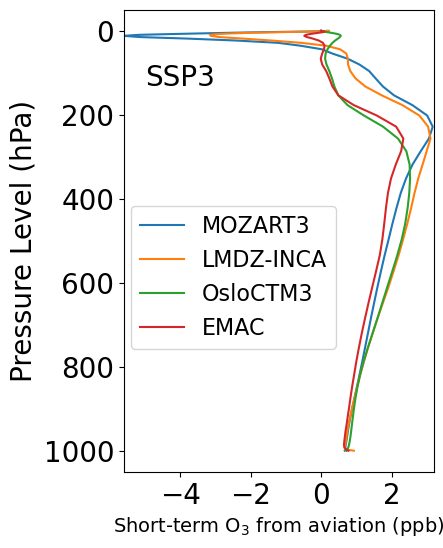

In [ ]:
plt.figure(figsize=(4, 6))

(o3_Rf_diff_SSP3_C1_1['vert_prof_O3'].sel(member='MOZART3')*5*1.18).plot.line(y='lev', yincrease=False,c='C0',label='MOZART3')


#o3_Rf_diff_SSP1BG_SSP3ems_C1_1['vert_prof_O3'].sel(member='LMDZ-INCA').plot.line(y='lev', yincrease=False,c='C1',linestyle=':')
o3_Rf_diff_SSP3_C1_2['vert_prof_O3'].sel(member='LMDZ-INCA').plot.line(y='lev', yincrease=False, c='C1',label='LMDZ-INCA')

#o3_Rf_diff_SSP1BG_SSP3ems_C1_1['vert_prof_O3'].sel(member='OsloCTM3').plot.line(y='lev', yincrease=False,c='C2',linestyle=':')
o3_Rf_diff_SSP3_C1_2['vert_prof_O3'].sel(member='OsloCTM3').plot.line(y='lev', yincrease=False, c='C2',label='OsloCTM3')
o3_Rf_diff_SSP3_C1_2['vert_prof_O3'].sel(member='EMAC').plot.line(y='lev', yincrease=False, c='C3',label='EMAC')

plt.xlim(-5.6,3.2)
plt.xlabel(f'Short-term O$_3$ from aviation (ppb)',fontsize=14)
plt.ylabel('Pressure Level (hPa)')
plt.text(-5,130,'SSP3')
plt.xticks(np.arange(-4,3,2))

plt.title('')
plt.legend(fontsize=16,bbox_to_anchor=(0.72,0.6))
plt.savefig(f'{plotdir}/ACACIA_O3conc_ssp3ems_vertical_Fig2b.pdf',format='pdf',bbox_inches='tight')

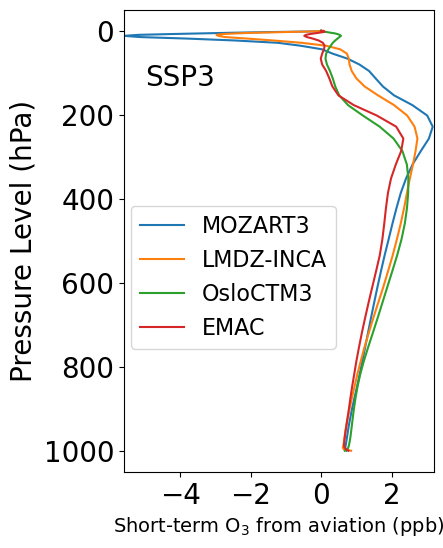

In [25]:
#Fig 2b
#Use 20% experiment and then scale using scaling factors
plt.figure(figsize=(4, 6))

(o3_Rf_diff_SSP3_C1_1['vert_prof_O3'].sel(member='MOZART3')*5*1.18).plot.line(y='lev', yincrease=False,c='C0',label='MOZART3')


#o3_Rf_diff_SSP1BG_SSP3ems_C1_1['vert_prof_O3'].sel(member='LMDZ-INCA').plot.line(y='lev', yincrease=False,c='C1',linestyle=':')
(o3_Rf_diff_SSP3_C1_1['vert_prof_O3'].sel(member='LMDZ-INCA')*5*1.03).plot.line(y='lev', yincrease=False, c='C1',label='LMDZ-INCA')

#o3_Rf_diff_SSP1BG_SSP3ems_C1_1['vert_prof_O3'].sel(member='OsloCTM3').plot.line(y='lev', yincrease=False,c='C2',linestyle=':')
(o3_Rf_diff_SSP3_C1_1['vert_prof_O3'].sel(member='OsloCTM3')*1.09*5).plot.line(y='lev', yincrease=False, c='C2',label='OsloCTM3')
o3_Rf_diff_SSP3_C1_2['vert_prof_O3'].sel(member='EMAC').plot.line(y='lev', yincrease=False, c='C3',label='EMAC')

plt.xlim(-5.6,3.2)
plt.xlabel(f'Short-term O$_3$ from aviation (ppb)',fontsize=14)
plt.ylabel('Pressure Level (hPa)')
plt.text(-5,130,'SSP3')
plt.xticks(np.arange(-4,3,2))

plt.title('')
plt.legend(fontsize=16,bbox_to_anchor=(0.72,0.6))
plt.savefig(f'{plotdir}/ACACIA_O3conc_ssp3ems_vertical_Fig2b_20pc.pdf',format='pdf',bbox_inches='tight')

Text(0.5, 1.0, 'Vertical Profile of O3 RF SSP1 C1.1 - C1')

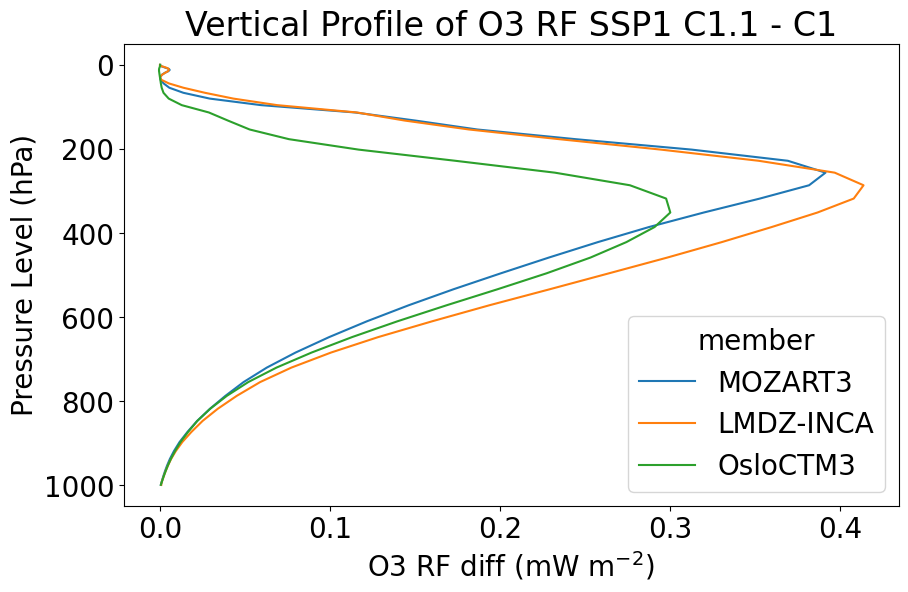

In [27]:
plt.figure(figsize=(10, 6))

ax = o3_Rf_diff_SSP1_C1_1['vert_prof_O3_RF'].plot.line(y='lev', yincrease=False)

plt.xlabel(f'O3 RF diff (mW m$^{{-2}}$)')
plt.ylabel('Pressure Level (hPa)')
plt.title('Vertical Profile of O3 RF SSP1 C1.1 - C1')
#plt.legend(fontsize=16)

Text(0.5, 1.0, 'Vertical Profile of O3 RF SSP3 C1.1 - C1')

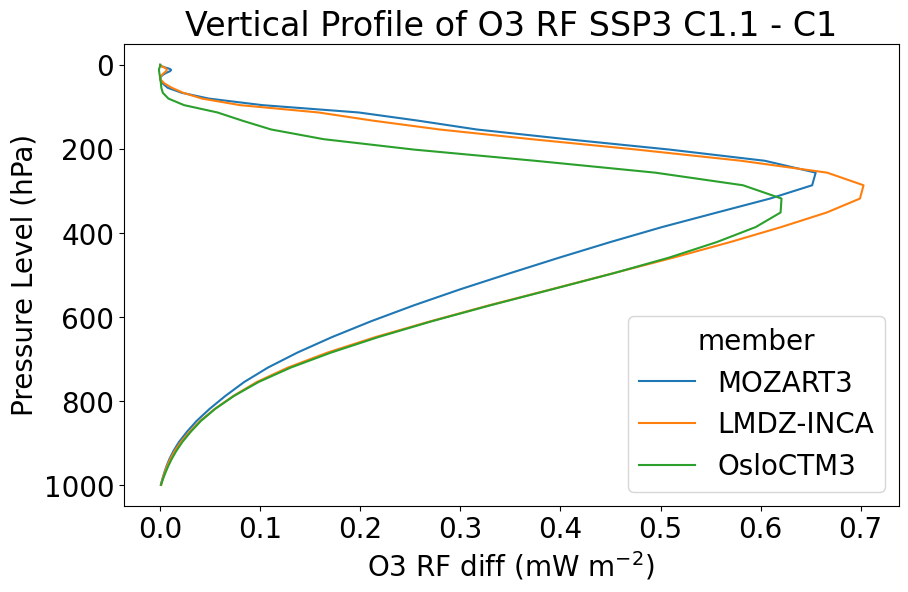

In [28]:
plt.figure(figsize=(10, 6))

ax = o3_Rf_diff_SSP3_C1_1['vert_prof_O3_RF'].plot.line(y='lev', yincrease=False)

plt.xlabel(f'O3 RF diff (mW m$^{{-2}}$)')
plt.ylabel('Pressure Level (hPa)')
plt.title('Vertical Profile of O3 RF SSP3 C1.1 - C1')
#plt.legend(fontsize=16)

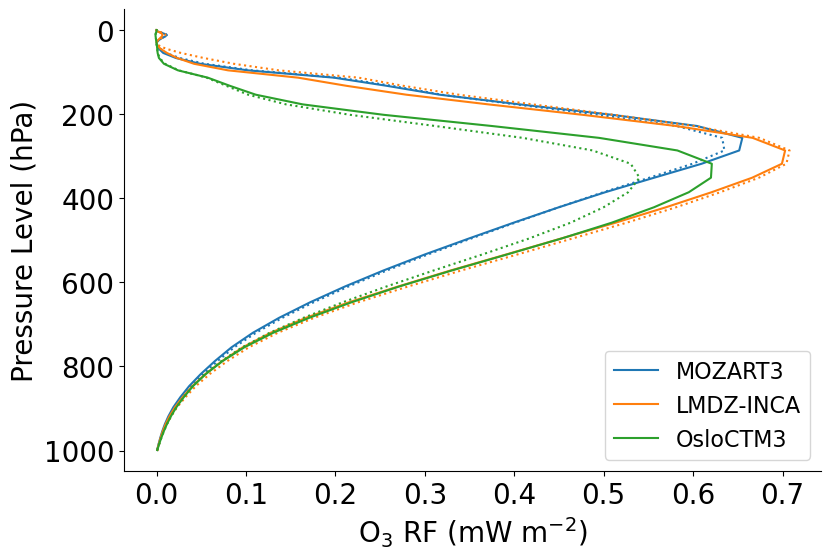

In [ ]:
#Fig 3b
plt.figure(figsize=(9, 6))

o3_Rf_diff_SSP1BG_SSP3ems_C1_1['vert_prof_O3_RF'].sel(member='MOZART3').plot.line(y='lev', yincrease=False,linestyle=':')
o3_Rf_diff_SSP3_C1_1['vert_prof_O3_RF'].sel(member='MOZART3').plot.line(y='lev', yincrease=False,c='C0',label='MOZART3')

o3_Rf_diff_SSP1BG_SSP3ems_C1_1['vert_prof_O3_RF'].sel(member='LMDZ-INCA').plot.line(y='lev', yincrease=False,c='C1',linestyle=':')
o3_Rf_diff_SSP3_C1_1['vert_prof_O3_RF'].sel(member='LMDZ-INCA').plot.line(y='lev', yincrease=False,c='C1',label='LMDZ-INCA')

o3_Rf_diff_SSP1BG_SSP3ems_C1_1['vert_prof_O3_RF'].sel(member='OsloCTM3').plot.line(y='lev', yincrease=False,c='C2',linestyle=':')
o3_Rf_diff_SSP3_C1_1['vert_prof_O3_RF'].sel(member='OsloCTM3').plot.line(y='lev', yincrease=False,c='C2',label='OsloCTM3')

plt.xlabel(f'O$_3$ RF (mW m$^{{-2}}$)')
plt.ylabel('Pressure Level (hPa)')
plt.title('')
#plt.title('Vertical Profile of O3 RF SSP3 C1.1 - C1')
plt.legend(fontsize=16)
plt.gca().spines[['right', 'top']].set_visible(False)

plt.savefig(f'{plotdir}/ACACIA_O3RF_vert_Fig3b.pdf',format='pdf',bbox_inches='tight')

### Vertical profile background difference

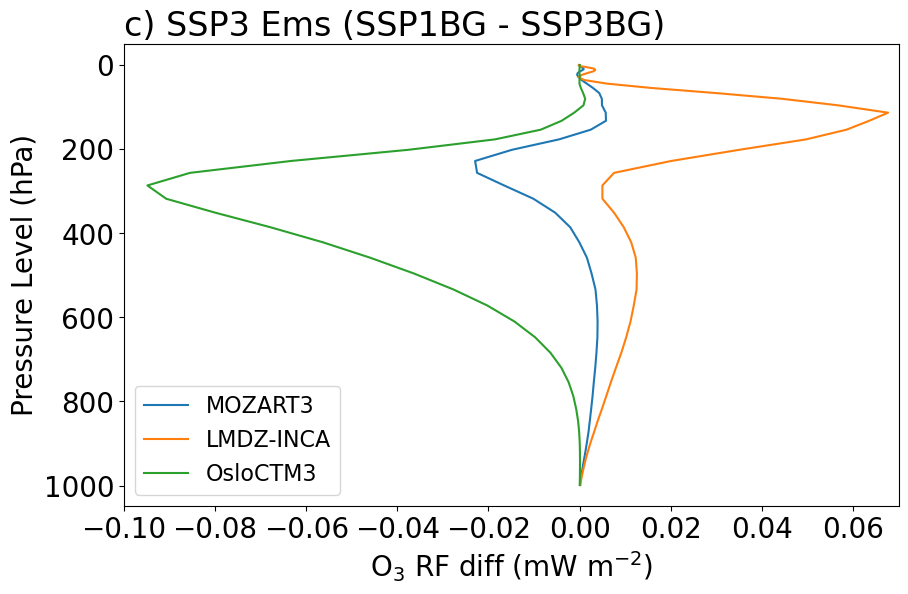

In [28]:
plt.figure(figsize=(10, 6))

(o3_Rf_diff_SSP1BG_SSP3ems_C1_1['vert_prof_O3_RF'] - o3_Rf_diff_SSP3_C1_1['vert_prof_O3_RF']).sel(member='MOZART3').plot.line(y='lev', yincrease=False,label='MOZART3')
#o3_Rf_diff_SSP3_C1_1['vert_prof_O3_RF'].sel(member='MOZART3').plot.line(y='lev', yincrease=False,linestyle=':',c='C0')

(o3_Rf_diff_SSP1BG_SSP3ems_C1_1['vert_prof_O3_RF'] - o3_Rf_diff_SSP3_C1_1['vert_prof_O3_RF']).sel(member='LMDZ-INCA').plot.line(y='lev', yincrease=False,c='C1',label='LMDZ-INCA')

(o3_Rf_diff_SSP1BG_SSP3ems_C1_1['vert_prof_O3_RF'] - o3_Rf_diff_SSP3_C1_1['vert_prof_O3_RF']).sel(member='OsloCTM3').plot.line(y='lev', yincrease=False,c='C2',label='OsloCTM3')

plt.xlabel(f'O$_3$ RF diff (mW m$^{{-2}}$)')
plt.ylabel('Pressure Level (hPa)')
plt.xlim(-0.1,0.07)
plt.title('c) SSP3 Ems (SSP1BG - SSP3BG)', loc='left')
plt.title('')
plt.legend(fontsize=16)
plt.savefig(f'{plotdir}/ACACIA_O3RF_SSP3ems_vertical_bgdiff_Fig4c.pdf',format='pdf',bbox_inches='tight')

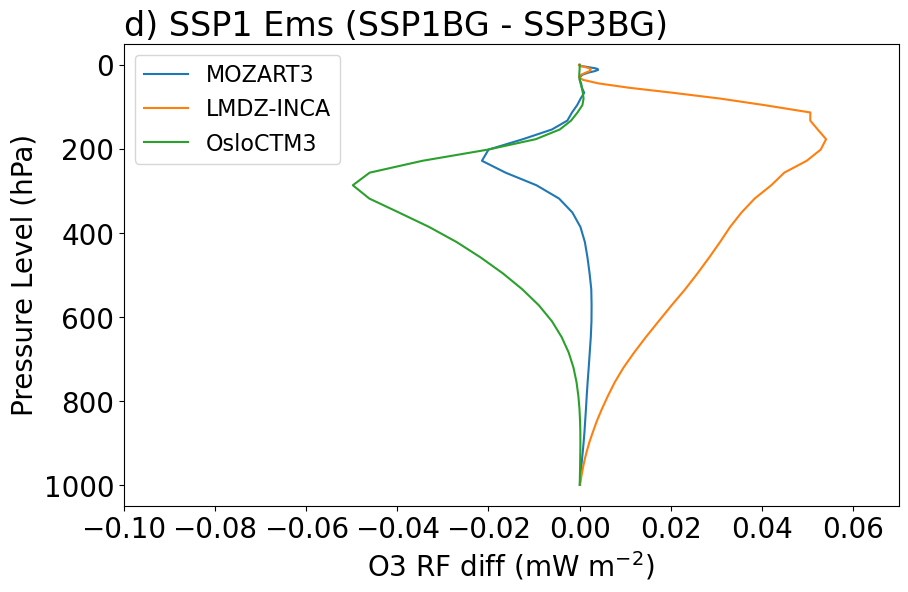

In [29]:
plt.figure(figsize=(10, 6))

(o3_Rf_diff_SSP1_C1_1['vert_prof_O3_RF'] - o3_Rf_diff_SSP3BG_SSP1ems_C1_1['vert_prof_O3_RF']).sel(member='MOZART3').plot.line(y='lev', yincrease=False,c='C0',label='MOZART3')
(o3_Rf_diff_SSP1_C1_1['vert_prof_O3_RF'] - o3_Rf_diff_SSP3BG_SSP1ems_C1_1['vert_prof_O3_RF']).sel(member='LMDZ-INCA').plot.line(y='lev', yincrease=False,c='C1',label='LMDZ-INCA')
(o3_Rf_diff_SSP1_C1_1['vert_prof_O3_RF'] - o3_Rf_diff_SSP3BG_SSP1ems_C1_1['vert_prof_O3_RF']).sel(member='OsloCTM3').plot.line(y='lev', yincrease=False,c='C2',label='OsloCTM3')


plt.xlabel(f'O3 RF diff (mW m$^{{-2}}$)')
plt.ylabel('Pressure Level (hPa)')
plt.xlim(-0.1,0.07)
plt.title('d) SSP1 Ems (SSP1BG - SSP3BG)', loc='left')
plt.title('')
#plt.title('O3 impact of -20% in SSP3 background vs SSP1 (SSP3-SSP1, SSP1 ems)')
plt.legend(fontsize=16)
plt.savefig(f'{plotdir}/ACACIA_O3RF_SSP1ems_vertical_bgdiff_Fig4d.pdf',format='pdf',bbox_inches='tight')

### Ozone RF bar chart with different backgrounds

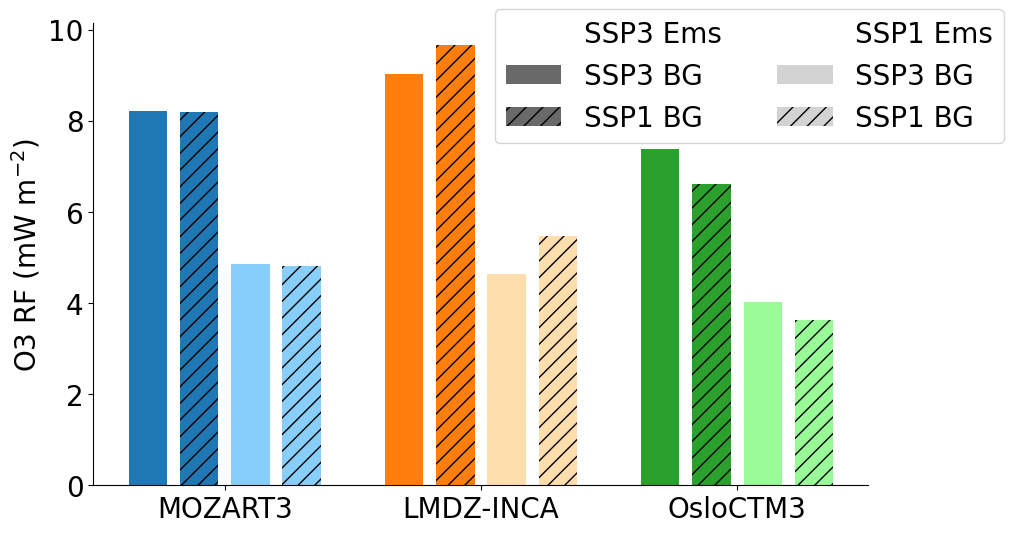

In [32]:
# Data
labels =['MOZART3','LMDZ-INCA','OsloCTM3']
values1 = o3_Rf_diff_SSP3_C1_1['O3_RF_sum'].values  # First bar in each pair
values2 = o3_Rf_diff_SSP1BG_SSP3ems_C1_1['O3_RF_sum'].values  # Second bar in each pair
values3 = o3_Rf_diff_SSP1_C1_1['O3_RF_sum'].values
values4 = o3_Rf_diff_SSP3BG_SSP1ems_C1_1['O3_RF_sum'].values

# Bar width and positions
x = np.arange(len(labels))
width = 0.15  # Reduced width to create gap
spacing = 0.05  # Small gap between bars

# Colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
colors2 = ['lightskyblue', 'navajowhite', 'palegreen']

# Create figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# Plot bars
bars1 = ax.bar(x - 0.3, values1, width, color=colors, label='Set 1')
bars2 = ax.bar(x - 0.1, values2, width, color=colors, hatch='//', label='Set 2')
bars3 = ax.bar(x + 0.1, values4, width, color=colors2, label='Set 3')
bars4 = ax.bar(x + 0.3, values3, width, color=colors2, hatch='//', label='Set 4')


legend_elements = [Patch(facecolor='white', label='SSP3 Ems'),
                   Patch(facecolor='dimgrey', label='SSP3 BG'),
                   Patch(facecolor='dimgrey', hatch='//', label='SSP1 BG'),
                   Patch(facecolor='white', label='SSP1 Ems'),
                   Patch(facecolor='lightgray', label='SSP3 BG'),
                   Patch(facecolor='lightgray', hatch='//', label='SSP1 BG')]

# Labels and title
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.spines[['right', 'top']].set_visible(False)

ax.set_ylabel(f'O3 RF (mW m$^{{-2}}$)')
#ax.set_title('Paired Bar Chart with Hatching')
ax.legend(handles=legend_elements, bbox_to_anchor=(0.5, 1.06), loc='upper left',ncol=2)
plt.savefig(f'{plotdir}/ACACIA_O3RF_bar_bgdiff_Fig3a.pdf',format='pdf',bbox_inches='tight')

### Ozone RF zonal mean plots

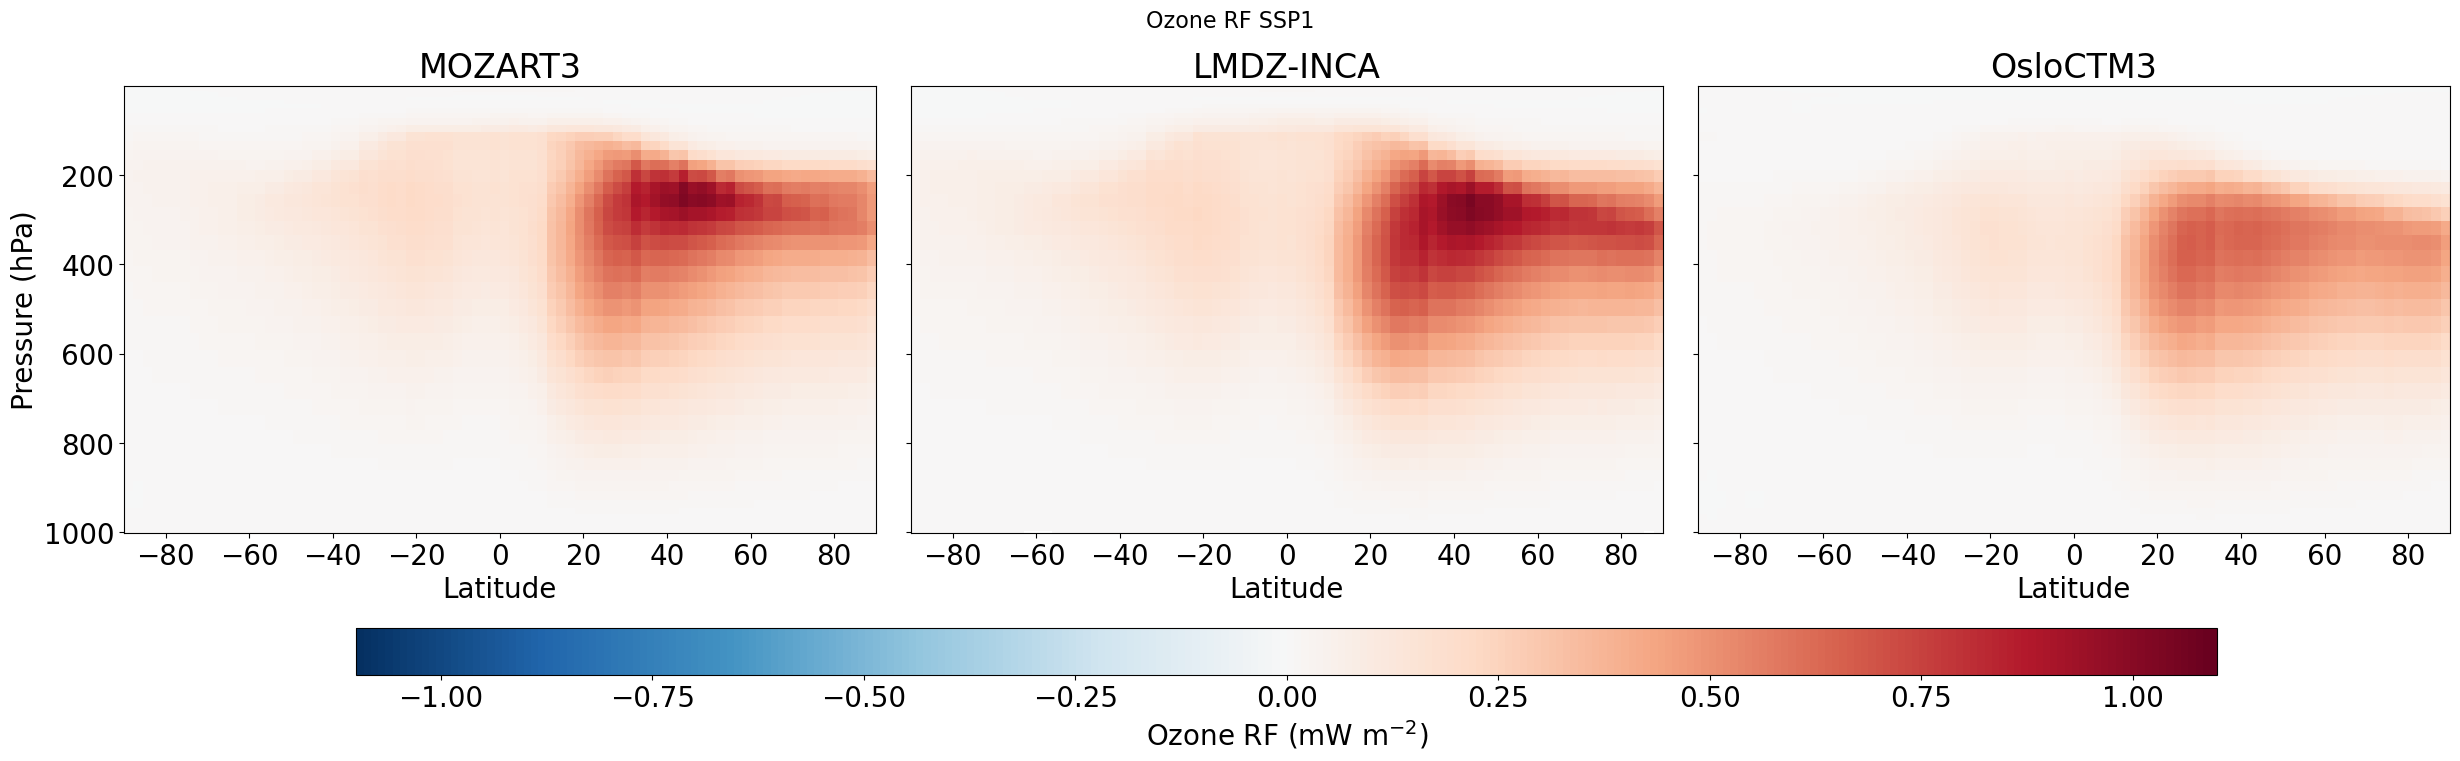

In [33]:
fg = (o3_Rf_diff_SSP1_C1_1['zon_mean_O3_RF']).plot(size=8,
    col="member",
    col_wrap=3,
    yincrease=False,
    vmax=1.1,
    #cmap="Reds",
    #transform=ccrs.PlateCarree(),  # remember to provide this!
    #subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40,"pad":0.15,"label":"Ozone RF (mW m$^{-2}$)"},
    robust=True,
)
fg.fig.suptitle('Ozone RF SSP1',y=1.02,fontsize=16)
fg.set_axis_labels('Latitude','Pressure (hPa)')
for ax, title in zip(fg.axs.flat, o3_Rf_diff_SSP1_C1_1.member.values):
    ax.set_title(title)

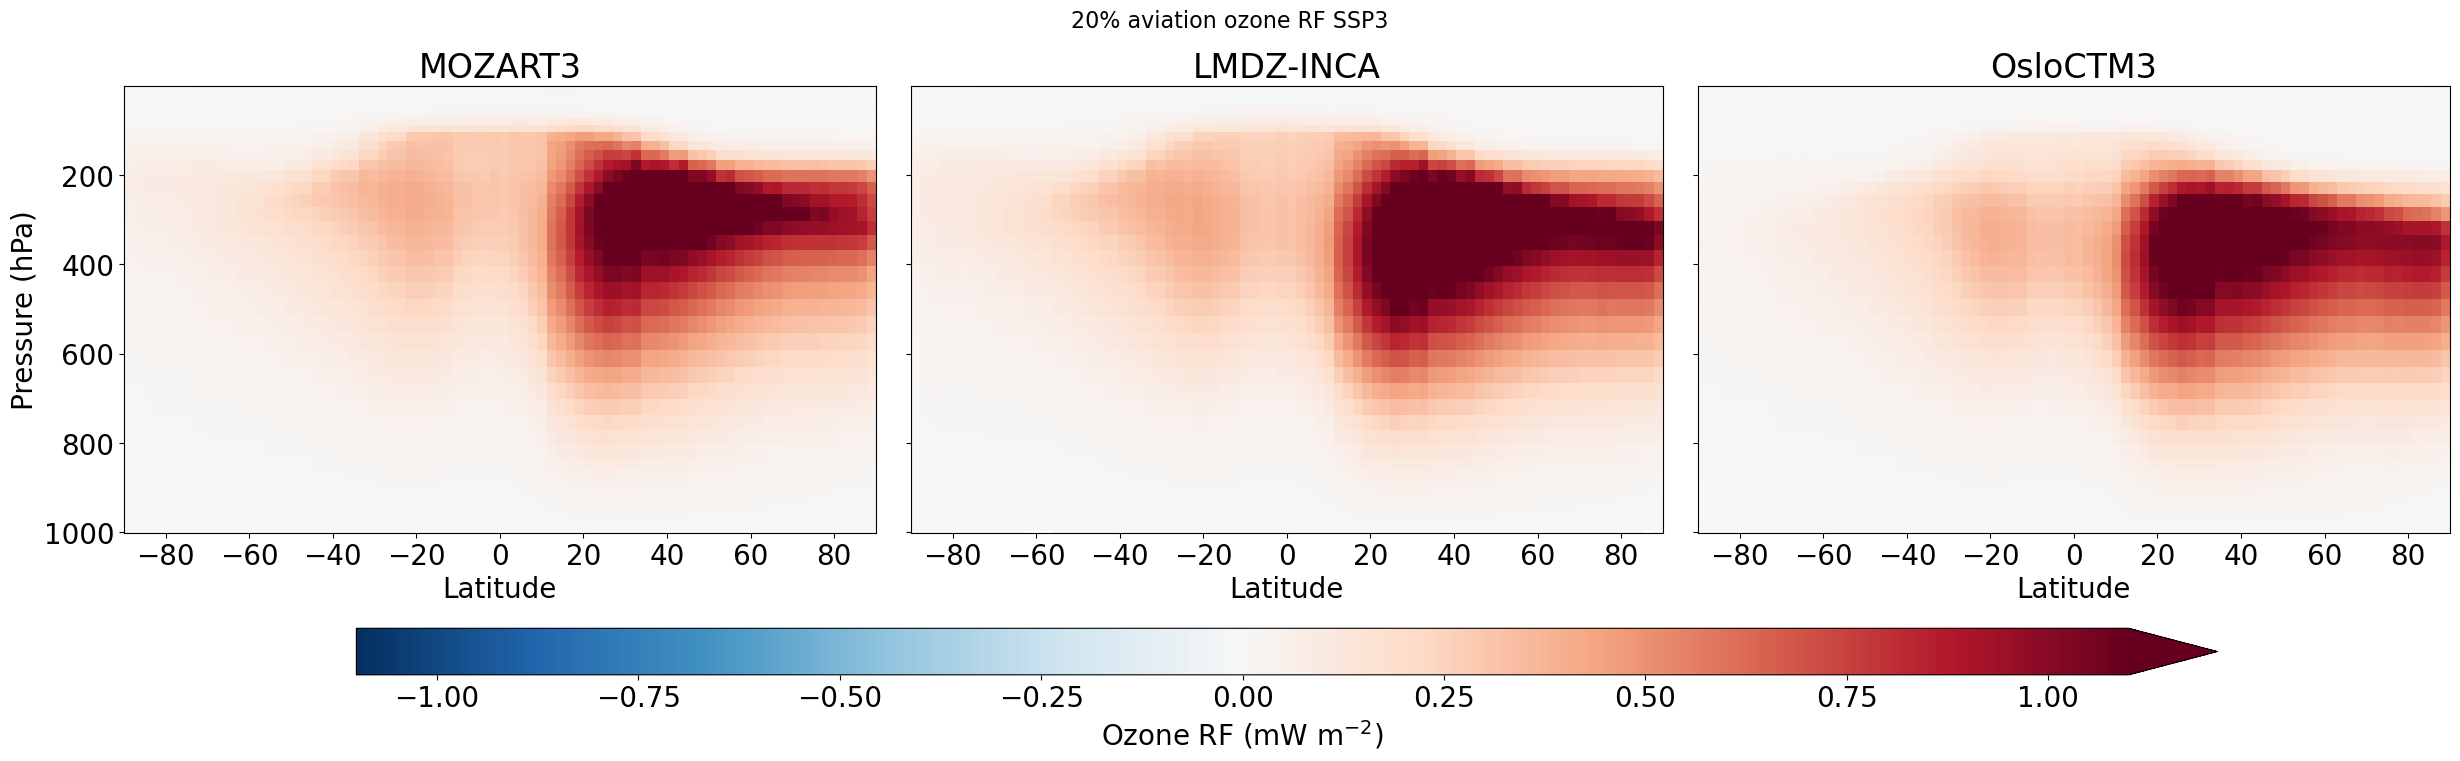

In [34]:
fg = (o3_Rf_diff_SSP3_C1_1['zon_mean_O3_RF']).plot(size=8,
    col="member",
    col_wrap=3,
    yincrease=False,
    vmax=1.1,
    #cmap="Reds",
    #transform=ccrs.PlateCarree(),  # remember to provide this!
    #subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40,"pad":0.15,"label":"Ozone RF (mW m$^{-2}$)"},
    robust=True,
)
fg.fig.suptitle('20% aviation ozone RF SSP3',y=1.02,fontsize=16)
fg.set_axis_labels('Latitude','Pressure (hPa)')
for ax, title in zip(fg.axs.flat, o3_Rf_diff_SSP1_C1_1.member.values):
    ax.set_title(title)

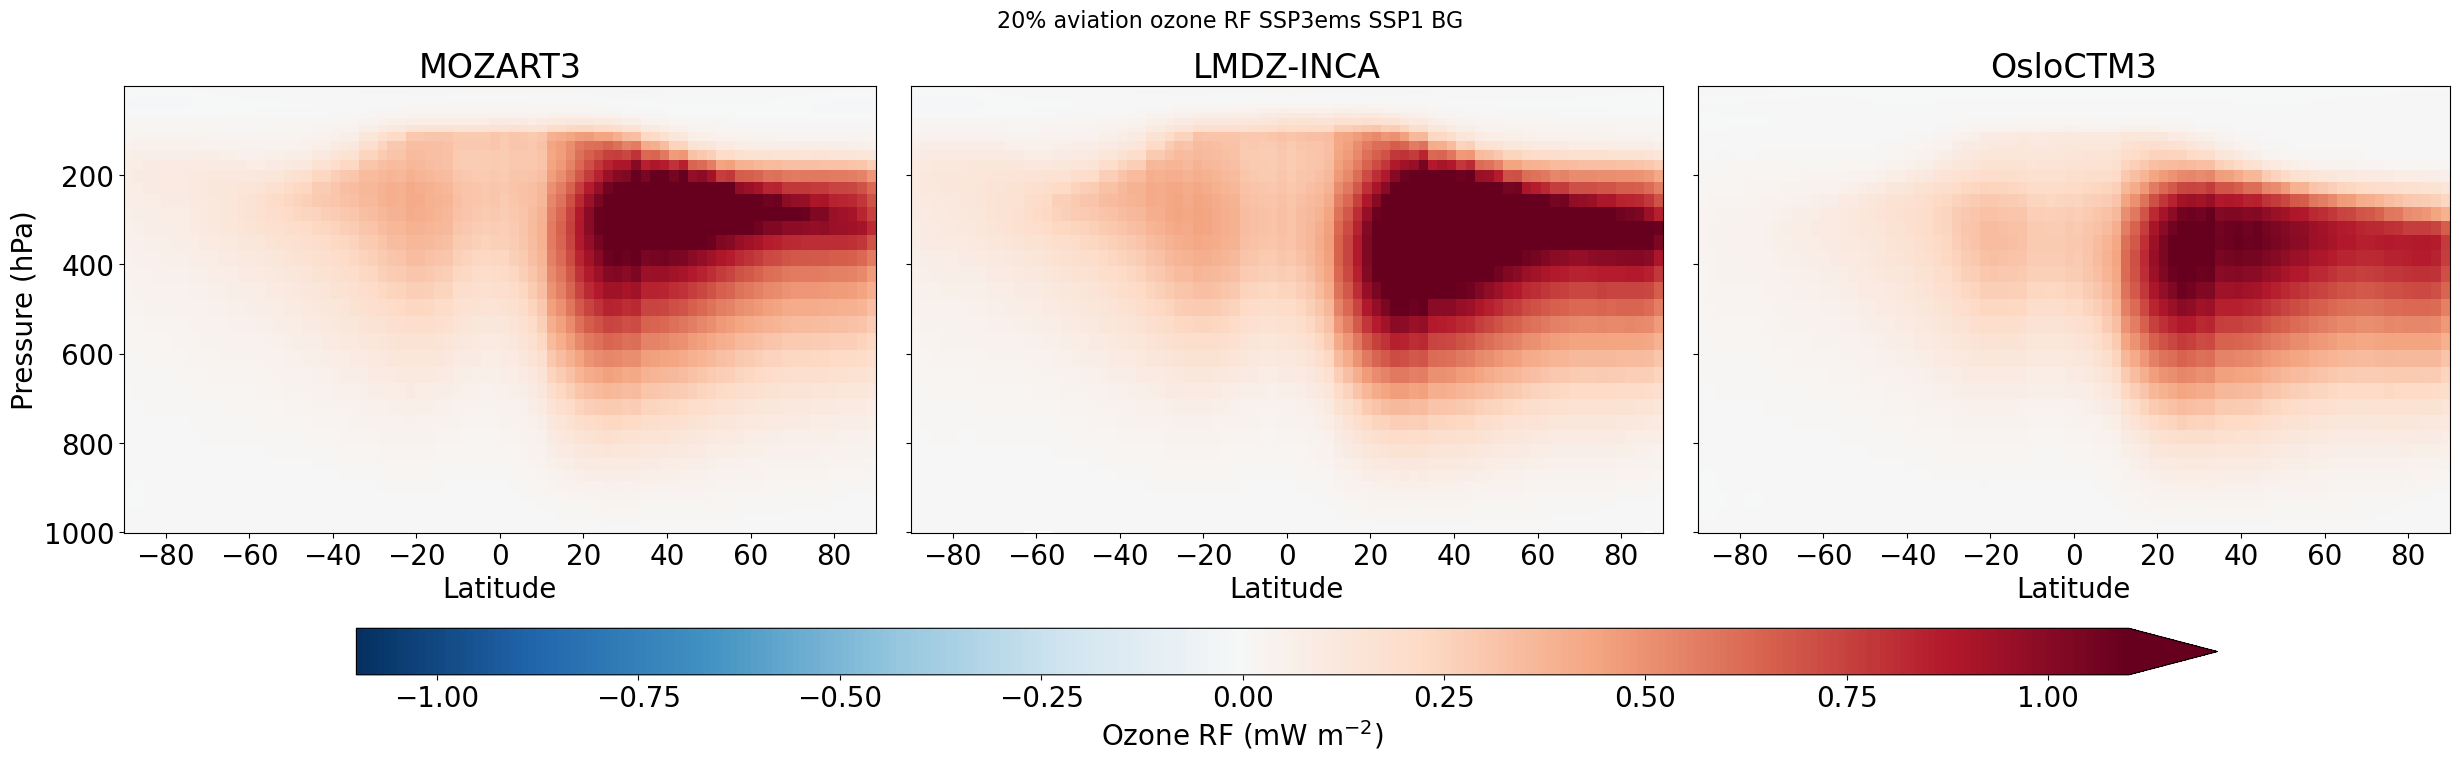

In [35]:
fg = (o3_Rf_diff_SSP1BG_SSP3ems_C1_1['zon_mean_O3_RF']).plot(size=8,
    col="member",
    col_wrap=3,
    yincrease=False,
    vmax=1.1,
    #cmap="Reds",
    #transform=ccrs.PlateCarree(),  # remember to provide this!
    #subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40,"pad":0.15,"label":"Ozone RF (mW m$^{-2}$)"},
    robust=True,
)
fg.fig.suptitle('20% aviation ozone RF SSP3ems SSP1 BG',y=1.02,fontsize=16)
fg.set_axis_labels('Latitude','Pressure (hPa)')
for ax, title in zip(fg.axs.flat, o3_Rf_diff_SSP1_C1_1.member.values):
    ax.set_title(title)

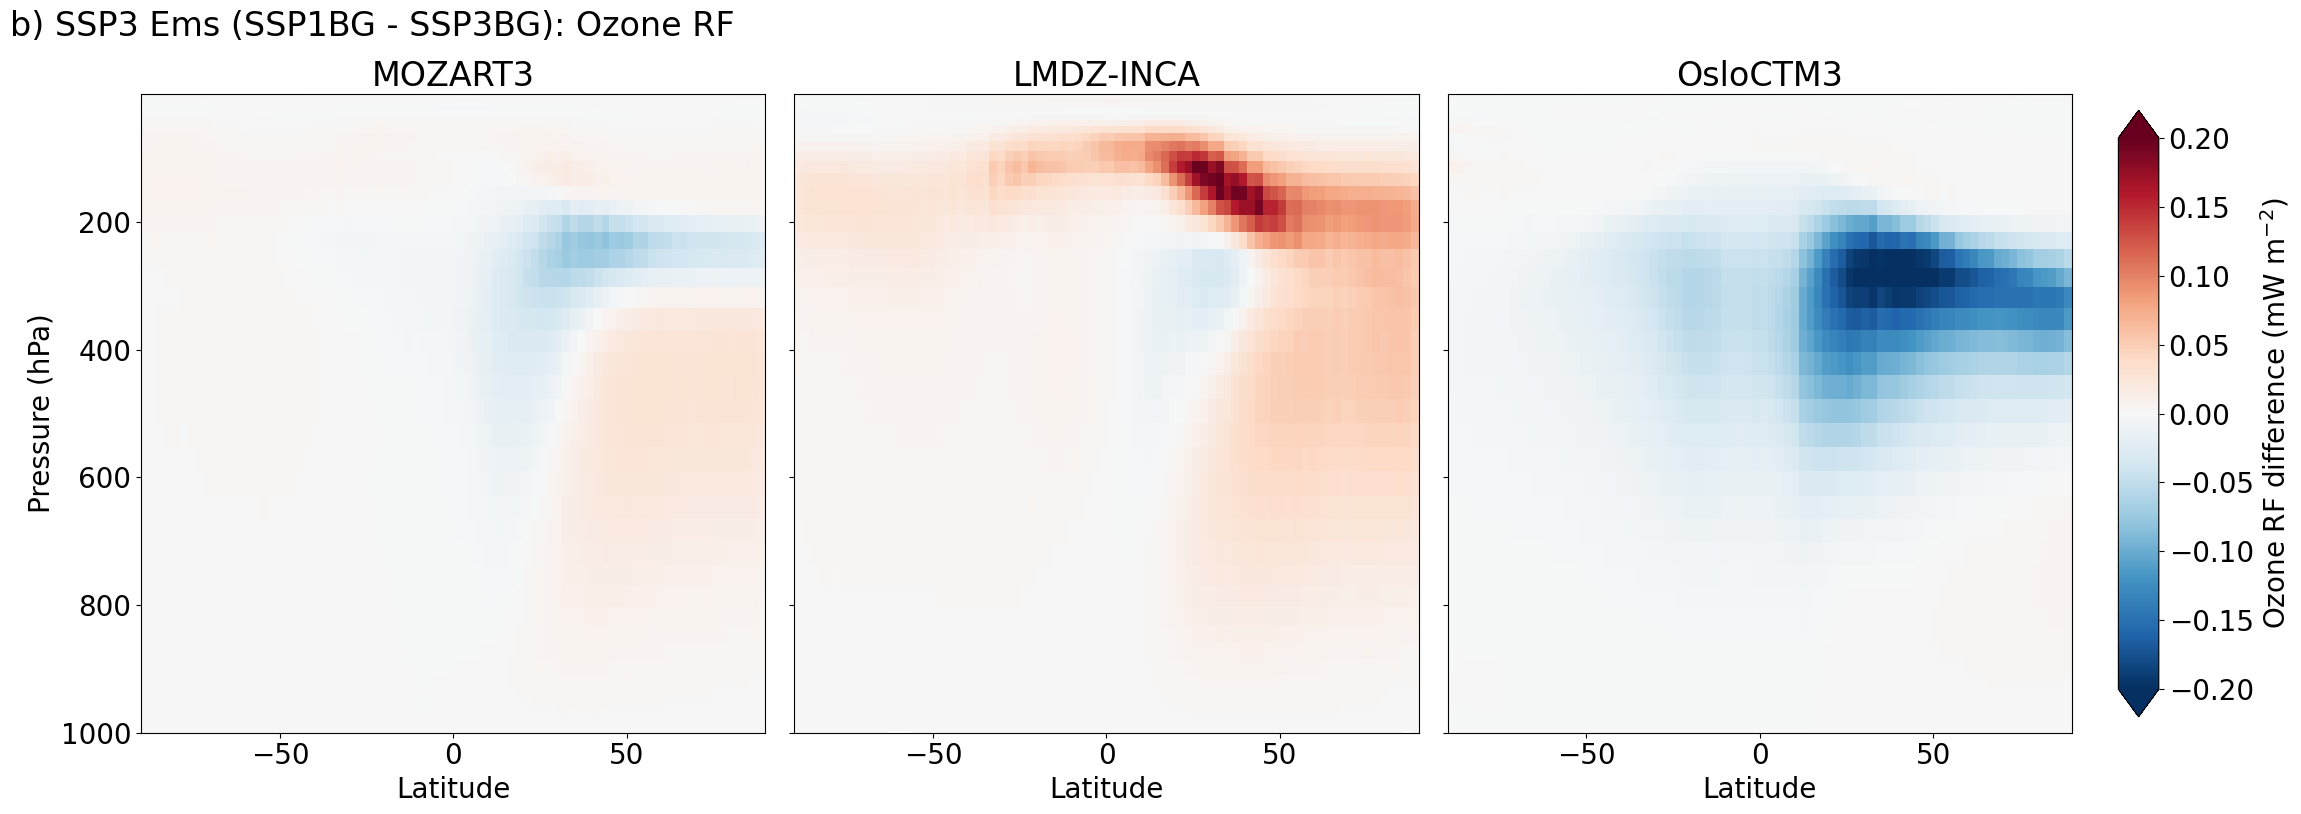

In [36]:
fg = (o3_Rf_diff_SSP1BG_SSP3ems_C1_1['zon_mean_O3_RF'] - o3_Rf_diff_SSP3_C1_1['zon_mean_O3_RF']).plot(size=8,
    col="member",
    col_wrap=3,
    yincrease=False,
    vmax=0.2,
    #cmap="Reds",
    #transform=ccrs.PlateCarree(),  # remember to provide this!
    #subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={"orientation": "vertical", "shrink": 0.95, "aspect": 15,"pad":0.02,"label":"Ozone RF difference (mW m$^{-2}$)"},
    robust=True,
)
fg.fig.suptitle('b) SSP3 Ems (SSP1BG - SSP3BG): Ozone RF',y=1.03,fontsize=24,x=0.15)
fg.set_axis_labels('Latitude','Pressure (hPa)')
for ax, title in zip(fg.axs.flat, o3_Rf_diff_SSP1_C1_1.member.values):
    ax.set_title(title)
plt.savefig(f'{plotdir}/ACACIA_O3RF_ssp3ems_zonal_bgdiff_Fig4b.pdf',format='pdf',bbox_inches='tight')

## Ozone mixing ratio

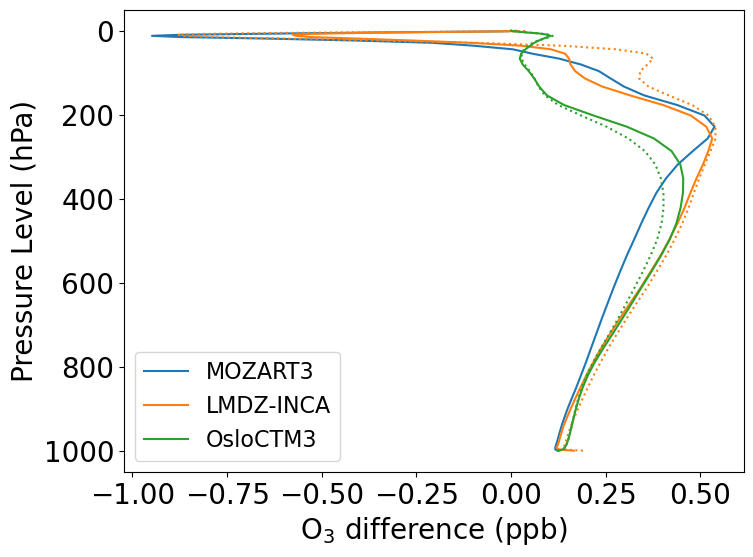

In [37]:
plt.figure(figsize=(8, 6))

#o3_Rf_diff_SSP1BG_SSP3ems_C1_1['vert_prof_O3'].sel(member='MOZART3').plot.line(y='lev', yincrease=False,linestyle=':')
o3_Rf_diff_SSP3_C1_1['vert_prof_O3'].sel(member='MOZART3').plot.line(y='lev', yincrease=False, c='C0',label='MOZART3')

o3_Rf_diff_SSP1BG_SSP3ems_C1_1['vert_prof_O3'].sel(member='LMDZ-INCA').plot.line(y='lev', yincrease=False,c='C1',linestyle=':')
o3_Rf_diff_SSP3_C1_1['vert_prof_O3'].sel(member='LMDZ-INCA').plot.line(y='lev', yincrease=False, c='C1',label='LMDZ-INCA')

o3_Rf_diff_SSP1BG_SSP3ems_C1_1['vert_prof_O3'].sel(member='OsloCTM3').plot.line(y='lev', yincrease=False,c='C2',linestyle=':')
o3_Rf_diff_SSP3_C1_1['vert_prof_O3'].sel(member='OsloCTM3').plot.line(y='lev', yincrease=False, c='C2',label='OsloCTM3')

plt.xlabel(f'O$_3$ difference (ppb)')
plt.ylabel('Pressure Level (hPa)')

plt.title('')
plt.legend(fontsize=16)
plt.savefig(f'{plotdir}/ACACIA_O3conc_ssp3ems_vertical_FigS1b.pdf',format='pdf',bbox_inches='tight')

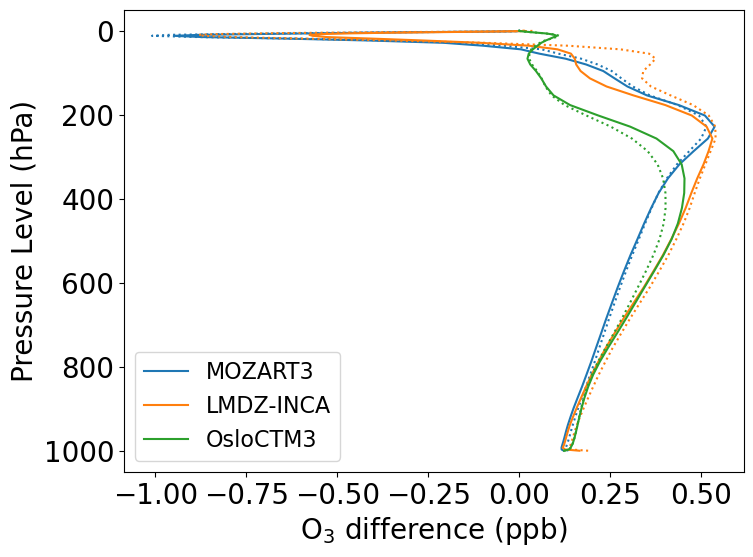

In [38]:
plt.figure(figsize=(8, 6))

o3_Rf_diff_SSP1BG_SSP3ems_C1_1['vert_prof_O3'].sel(member='MOZART3').plot.line(y='lev', yincrease=False,linestyle=':')
o3_Rf_diff_SSP3_C1_1['vert_prof_O3'].sel(member='MOZART3').plot.line(y='lev', yincrease=False, c='C0',label='MOZART3')

o3_Rf_diff_SSP1BG_SSP3ems_C1_1['vert_prof_O3'].sel(member='LMDZ-INCA').plot.line(y='lev', yincrease=False,c='C1',linestyle=':')
o3_Rf_diff_SSP3_C1_1['vert_prof_O3'].sel(member='LMDZ-INCA').plot.line(y='lev', yincrease=False, c='C1',label='LMDZ-INCA')

o3_Rf_diff_SSP1BG_SSP3ems_C1_1['vert_prof_O3'].sel(member='OsloCTM3').plot.line(y='lev', yincrease=False,c='C2',linestyle=':')
o3_Rf_diff_SSP3_C1_1['vert_prof_O3'].sel(member='OsloCTM3').plot.line(y='lev', yincrease=False, c='C2',label='OsloCTM3')

plt.xlabel(f'O$_3$ difference (ppb)')
plt.ylabel('Pressure Level (hPa)')

plt.title('')
plt.legend(fontsize=16)
plt.savefig(f'{plotdir}/ACACIA_O3conc_ssp3ems_vertical_FigS1b.pdf',format='pdf',bbox_inches='tight')

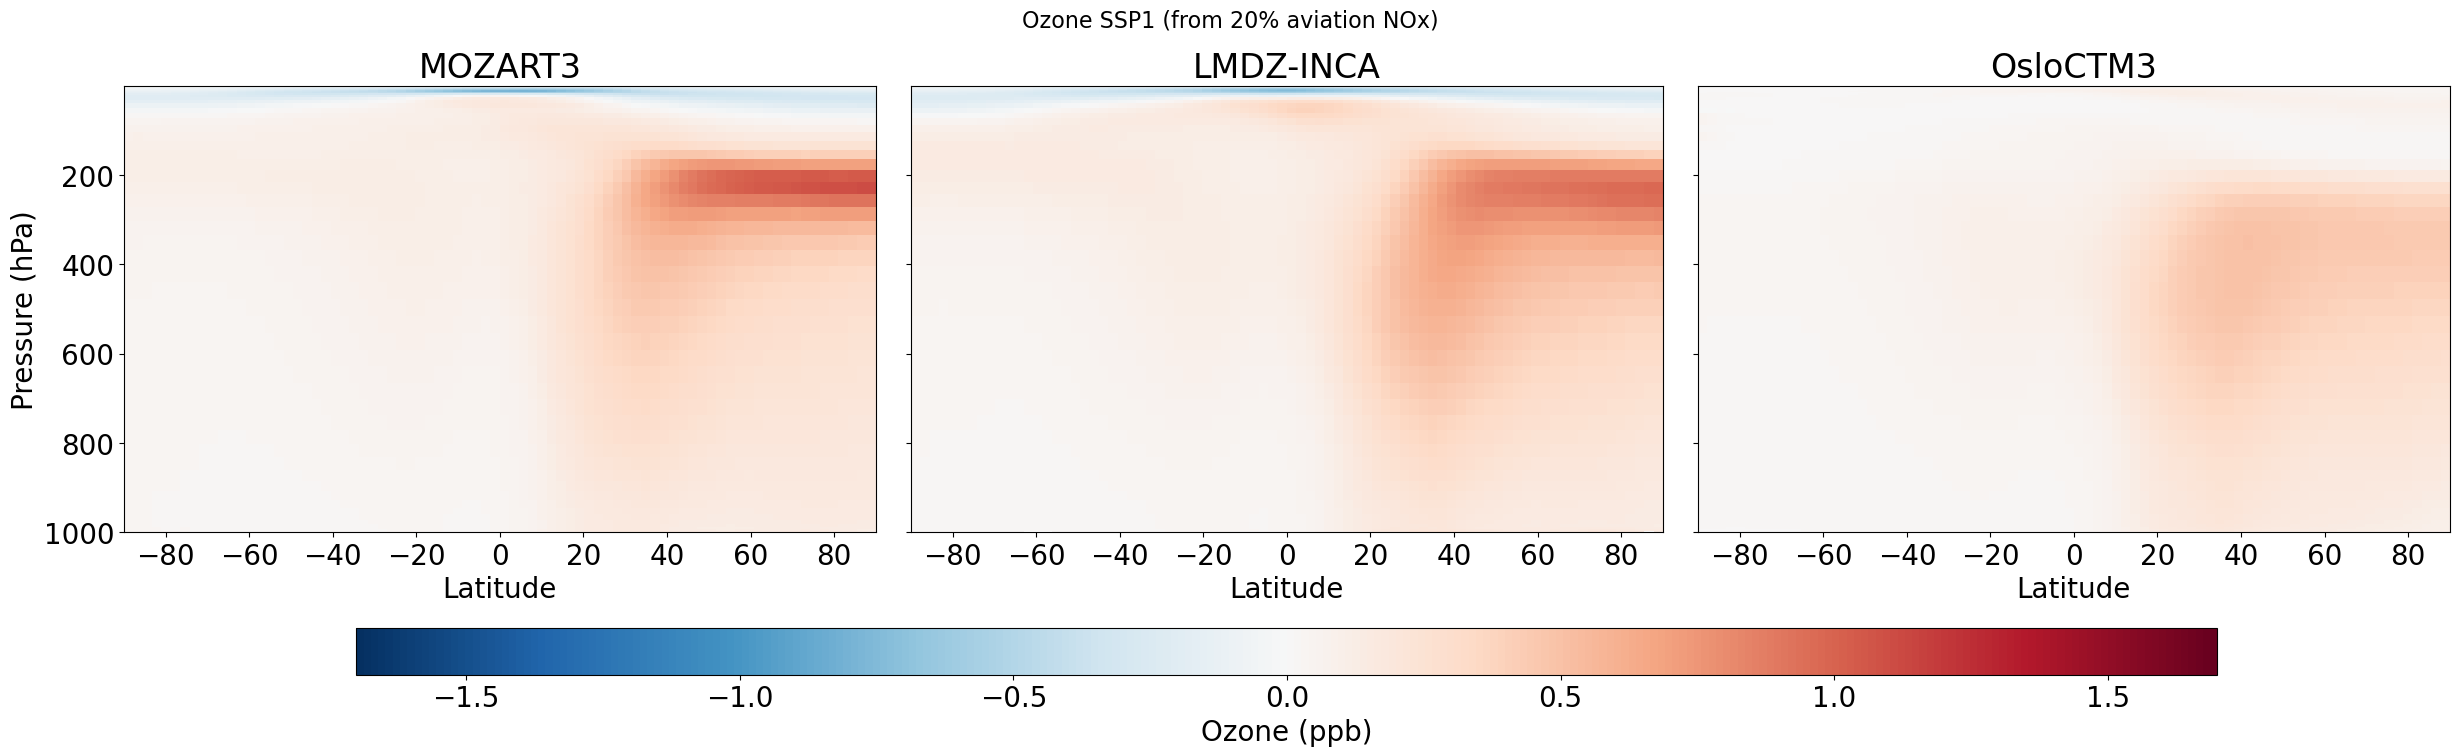

In [39]:
fg = (o3_Rf_diff_SSP1_C1_1['zon_mean_O3']).plot(size=8,
    col="member",
    col_wrap=3,
    yincrease=False,
    vmax=1.7,
    #cmap="Reds",
    #transform=ccrs.PlateCarree(),  # remember to provide this!
    #subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40,"pad":0.15,"label":"Ozone (ppb)"},
    robust=True,
)
fg.fig.suptitle('Ozone SSP1 (from 20% aviation NOx)',y=1.02,fontsize=16)
fg.set_axis_labels('Latitude','Pressure (hPa)')
for ax, title in zip(fg.axs.flat, o3_Rf_diff_SSP1_C1_1.member.values):
    ax.set_title(title)

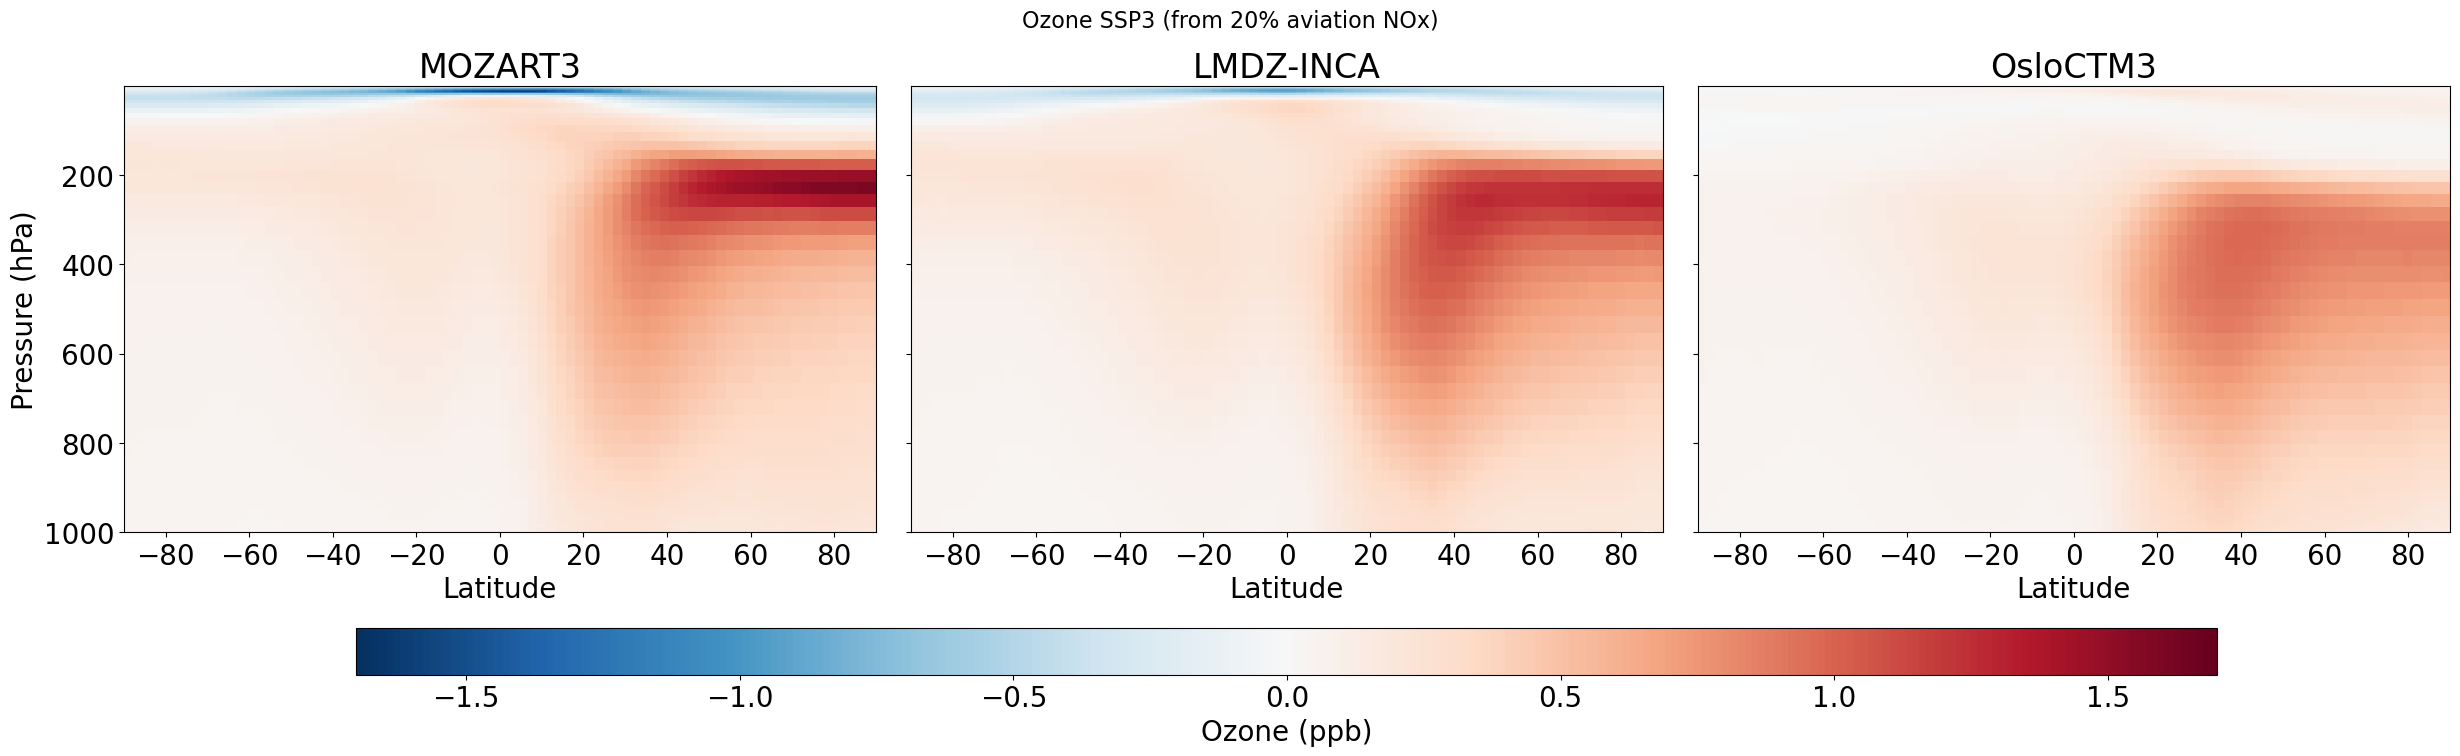

In [40]:
fg = (o3_Rf_diff_SSP3_C1_1['zon_mean_O3']).plot(size=8,
    col="member",
    col_wrap=3,
    yincrease=False,
    vmax=1.7,
    #cmap="Reds",
    #transform=ccrs.PlateCarree(),  # remember to provide this!
    #subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40,"pad":0.15,"label":"Ozone (ppb)"},
    robust=True,
)
fg.fig.suptitle('Ozone SSP3 (from 20% aviation NOx)',y=1.02,fontsize=16)
fg.set_axis_labels('Latitude','Pressure (hPa)')
for ax, title in zip(fg.axs.flat, o3_Rf_diff_SSP1_C1_1.member.values):
    ax.set_title(title)

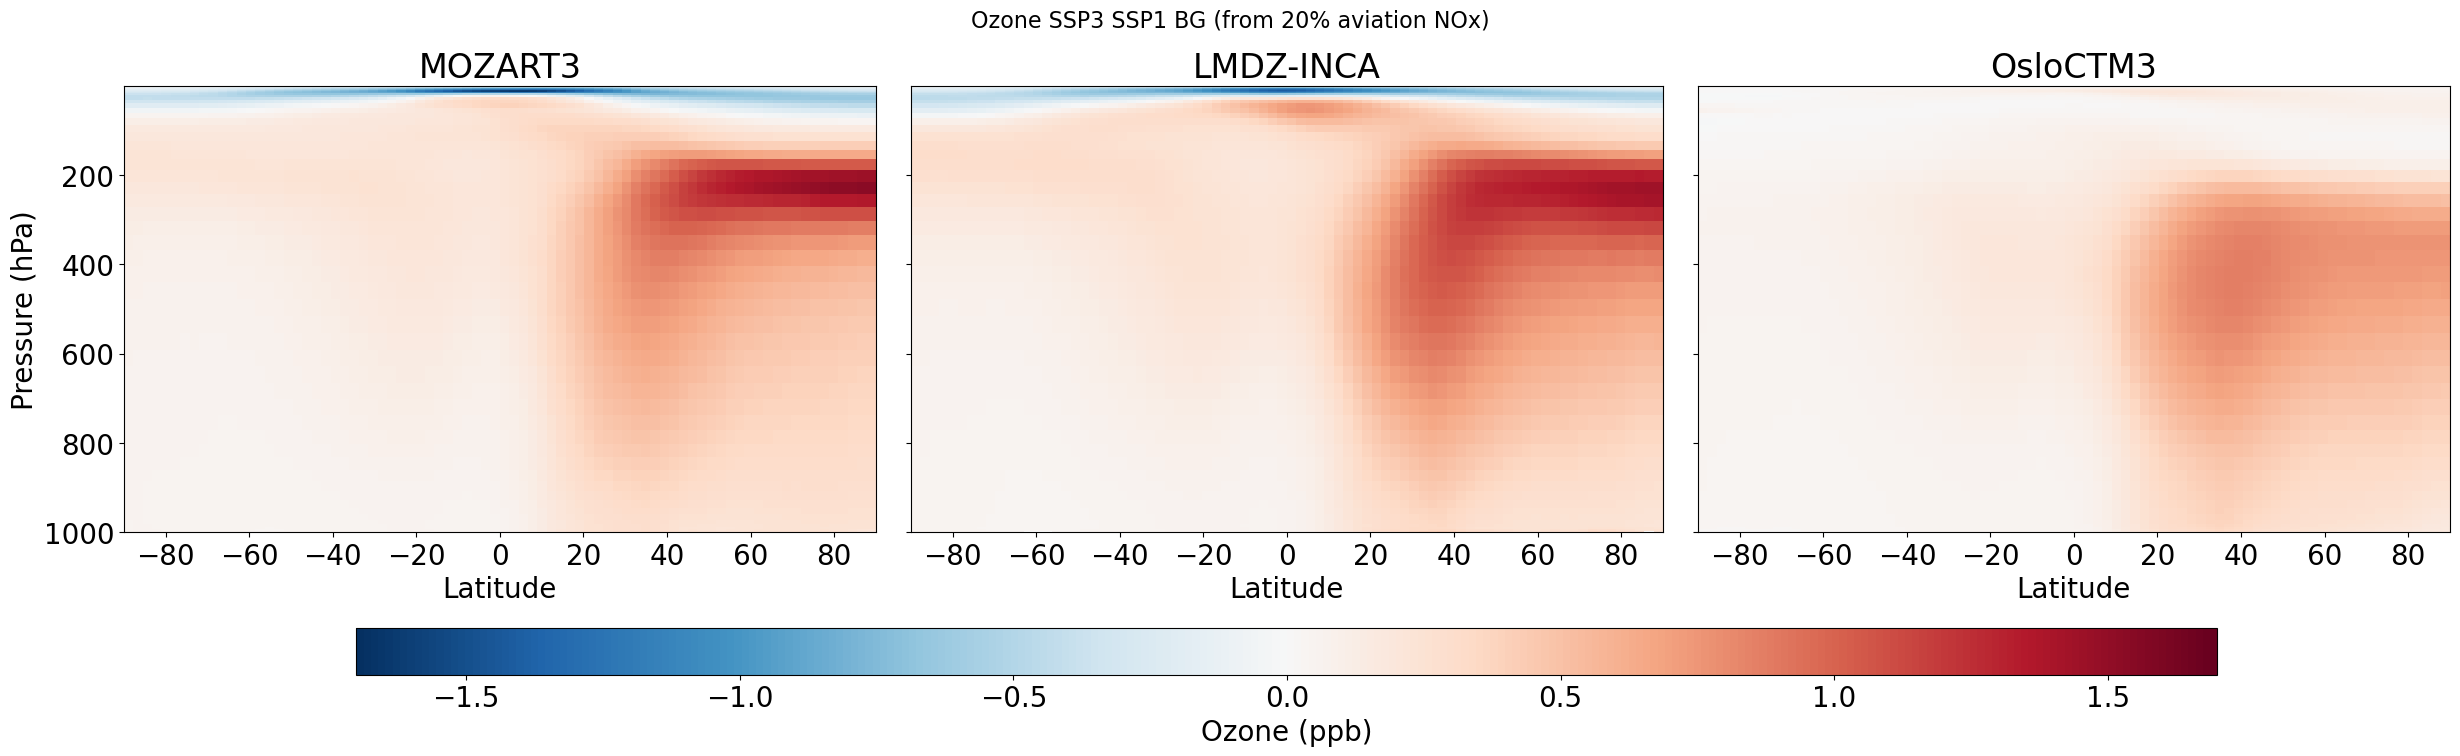

In [41]:
fg = (o3_Rf_diff_SSP1BG_SSP3ems_C1_1['zon_mean_O3']).plot(size=8,
    col="member",
    col_wrap=3,
    yincrease=False,
    vmax=1.7,
    #cmap="Reds",
    #transform=ccrs.PlateCarree(),  # remember to provide this!
    #subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40,"pad":0.15,"label":"Ozone (ppb)"},
    robust=True,
)
fg.fig.suptitle('Ozone SSP3 SSP1 BG (from 20% aviation NOx)',y=1.02,fontsize=16)
fg.set_axis_labels('Latitude','Pressure (hPa)')
for ax, title in zip(fg.axs.flat, o3_Rf_diff_SSP1_C1_1.member.values):
    ax.set_title(title)

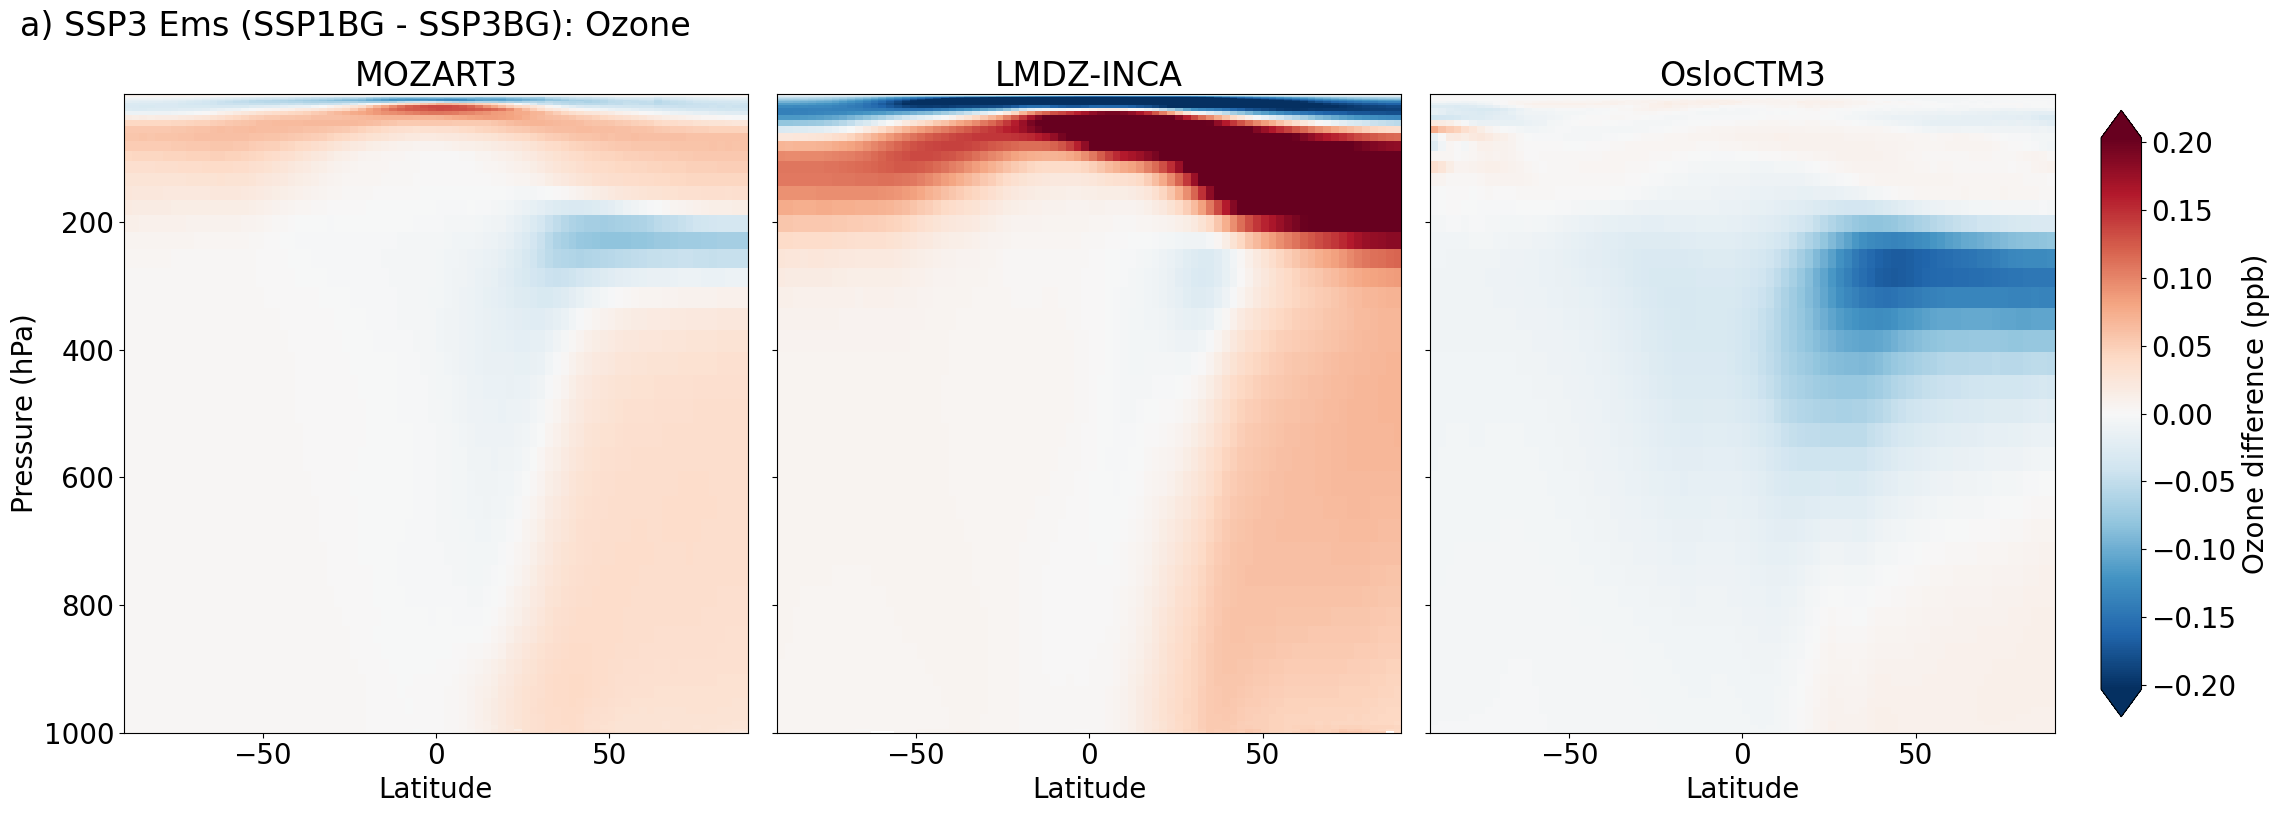

In [42]:
fg = (o3_Rf_diff_SSP1BG_SSP3ems_C1_1['zon_mean_O3'] - o3_Rf_diff_SSP3_C1_1['zon_mean_O3']).plot(size=8,
    col="member",
    col_wrap=3,
    yincrease=False,
    #vmax=1.7,
    #cmap="Reds",
    #transform=ccrs.PlateCarree(),  # remember to provide this!
    #subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={"orientation": "vertical", "shrink": 0.95, "aspect": 15,"pad":0.02,"label":"Ozone difference (ppb)"},
    robust=True,
)
fg.fig.suptitle('a) SSP3 Ems (SSP1BG - SSP3BG): Ozone',y=1.03,fontsize=24,x=0.15)
fg.set_axis_labels('Latitude','Pressure (hPa)')
for ax, title in zip(fg.axs.flat, o3_Rf_diff_SSP1_C1_1.member.values):
    ax.set_title(title)
plt.savefig(f'{plotdir}/ACACIA_O3conc_ssp3ems_zonal_bgdiff_Fig4a.pdf',format='pdf',bbox_inches='tight')

### Supplementary Figs

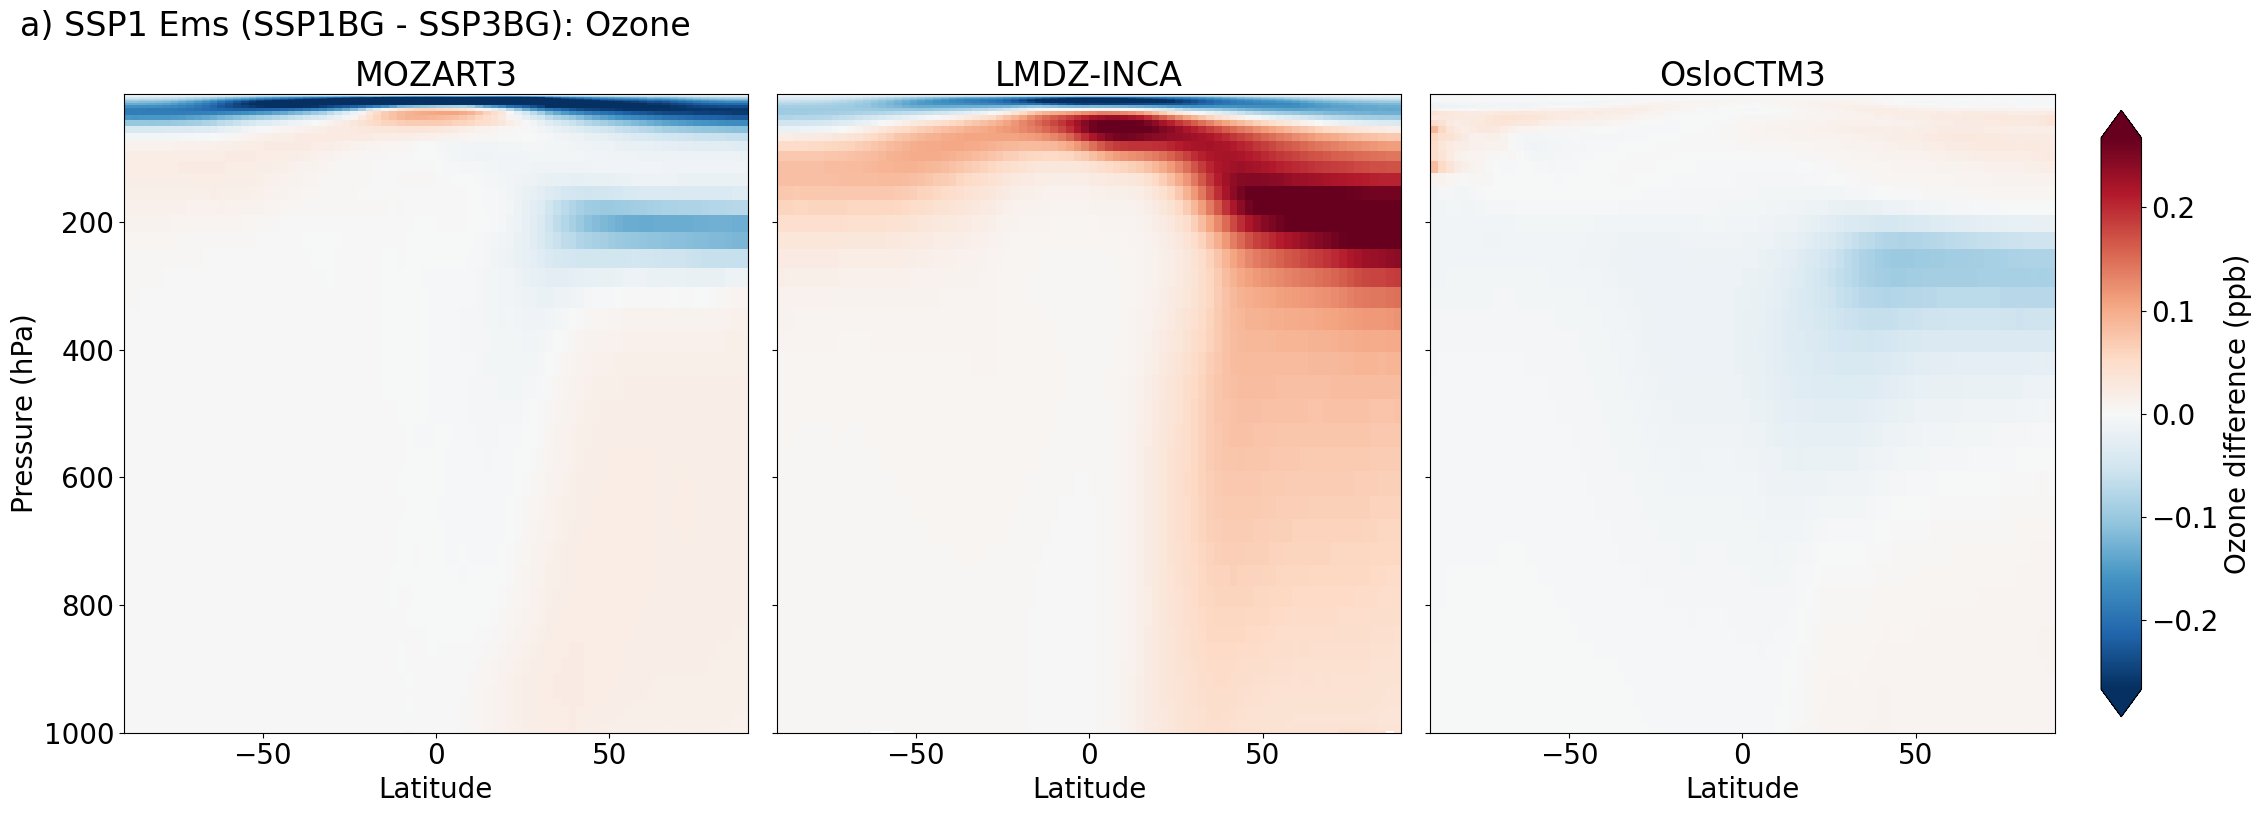

In [43]:
fg = (o3_Rf_diff_SSP1_C1_1['zon_mean_O3'] - o3_Rf_diff_SSP3BG_SSP1ems_C1_1['zon_mean_O3']).plot(size=8,
    col="member",
    col_wrap=3,
    yincrease=False,
    #vmax=1.7,
    #cmap="Reds",
    #transform=ccrs.PlateCarree(),  # remember to provide this!
    #subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={"orientation": "vertical", "shrink": 0.95, "aspect": 15,"pad":0.02,"label":"Ozone difference (ppb)"},
    robust=True,
)
fg.fig.suptitle('a) SSP1 Ems (SSP1BG - SSP3BG): Ozone',y=1.03,fontsize=24,x=0.15)
fg.set_axis_labels('Latitude','Pressure (hPa)')
for ax, title in zip(fg.axs.flat, o3_Rf_diff_SSP1_C1_1.member.values):
    ax.set_title(title)
plt.savefig(f'{plotdir}/ACACIA_O3conc_ssp1ems_zonal_bgdiff_FigS2a.pdf',format='pdf',bbox_inches='tight')

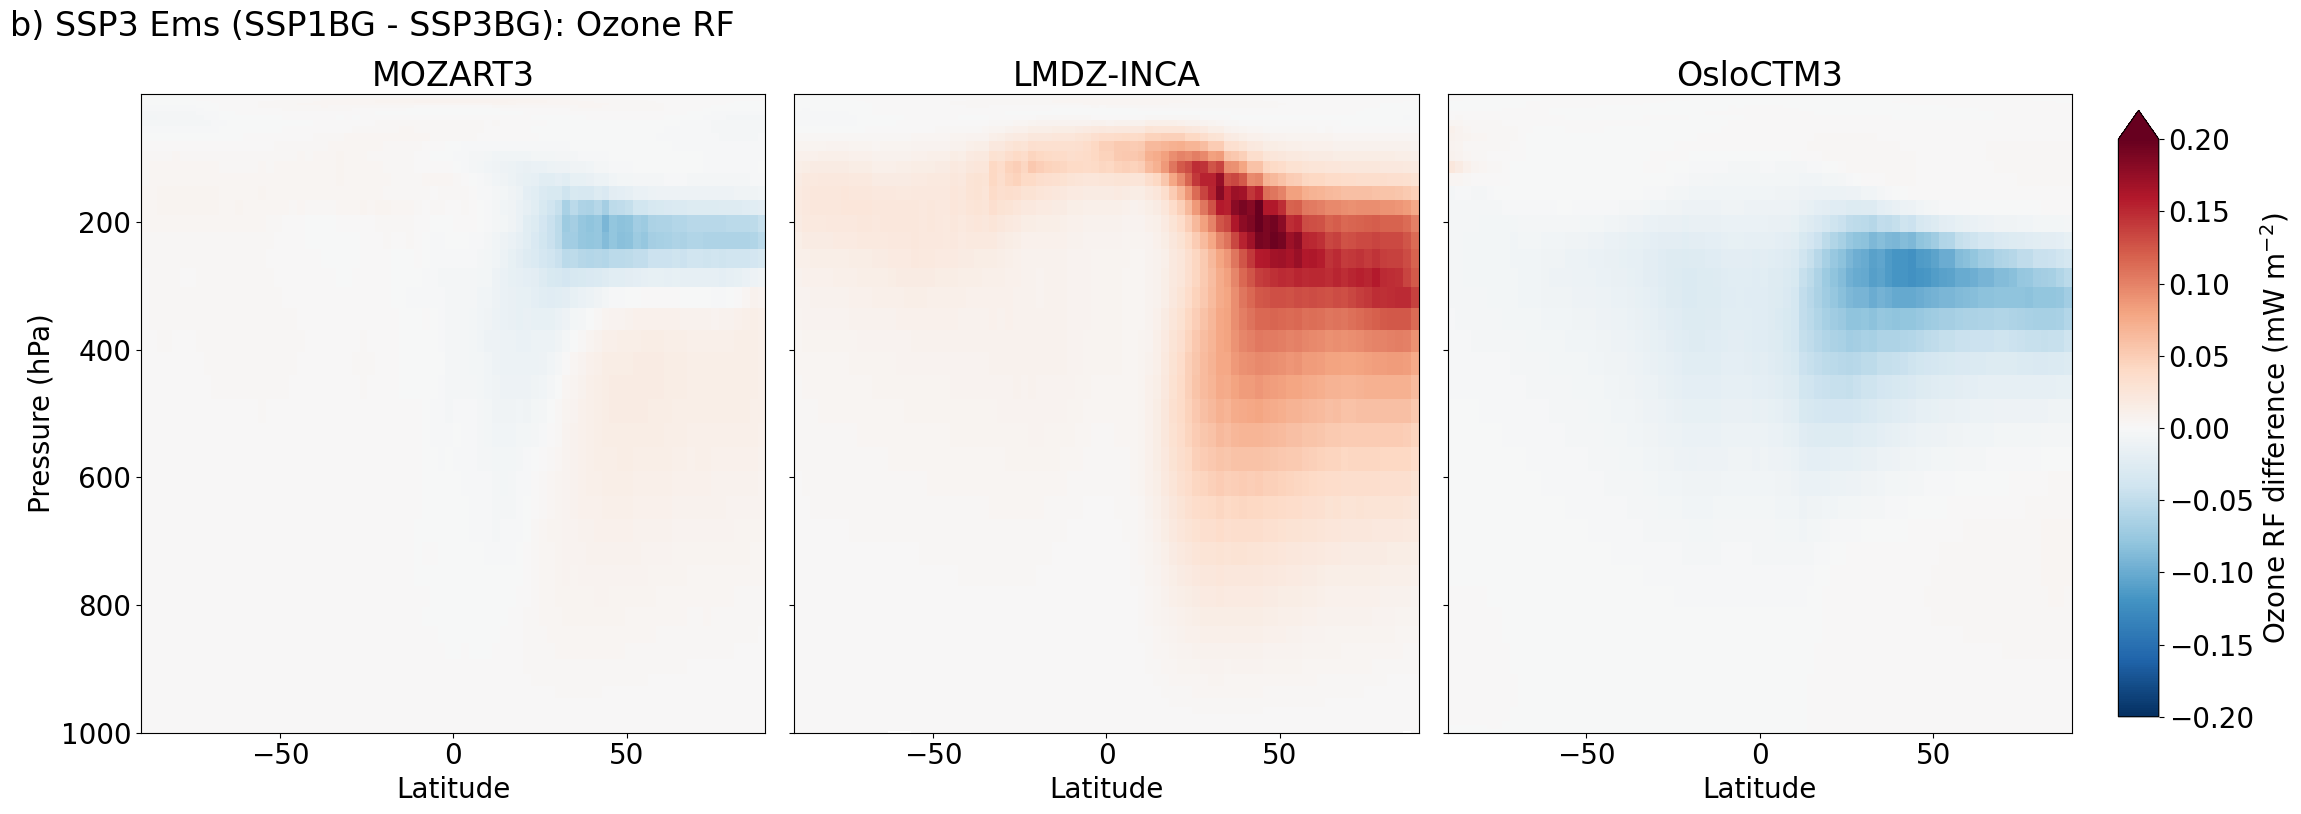

In [44]:
fg = (o3_Rf_diff_SSP1_C1_1['zon_mean_O3_RF'] - o3_Rf_diff_SSP3BG_SSP1ems_C1_1['zon_mean_O3_RF']).plot(size=8,
    col="member",
    col_wrap=3,
    yincrease=False,
    vmax=0.2,
    #cmap="Reds",
    #transform=ccrs.PlateCarree(),  # remember to provide this!
    #subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={"orientation": "vertical", "shrink": 0.95, "aspect": 15,"pad":0.02,"label":"Ozone RF difference (mW m$^{-2}$)"},
    robust=True,
)
fg.fig.suptitle('b) SSP3 Ems (SSP1BG - SSP3BG): Ozone RF',y=1.03,fontsize=24,x=0.15)
fg.set_axis_labels('Latitude','Pressure (hPa)')
for ax, title in zip(fg.axs.flat, o3_Rf_diff_SSP1_C1_1.member.values):
    ax.set_title(title)
plt.savefig(f'{plotdir}/ACACIA_O3RF_ssp1ems_zonal_bgdiff_FigS2b.pdf',format='pdf',bbox_inches='tight')

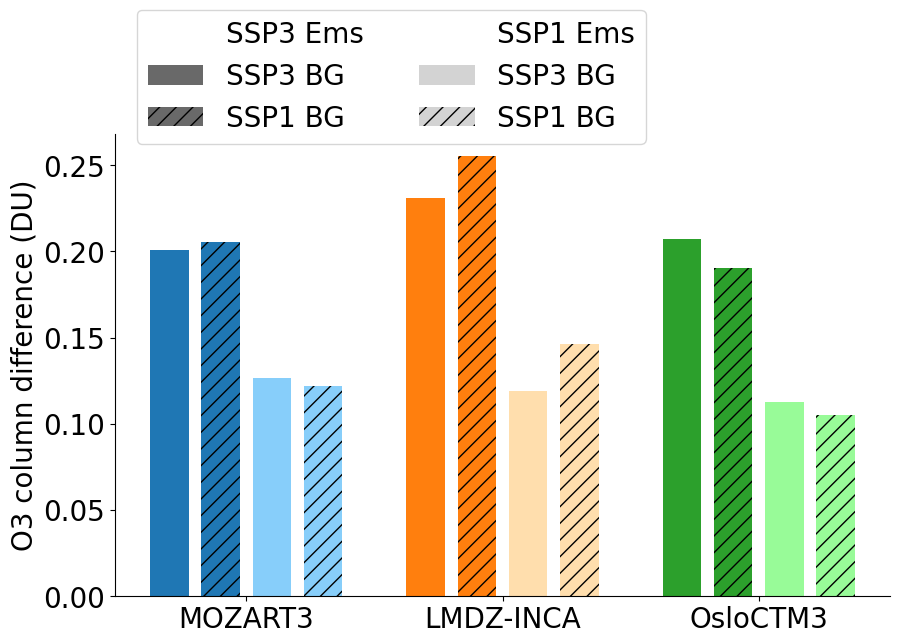

In [45]:
# Data
labels =['MOZART3','LMDZ-INCA','OsloCTM3']
values1 = o3_Rf_diff_SSP3_C1_1['o3_DU_sum'].values  # First bar in each pair
values2 = o3_Rf_diff_SSP1BG_SSP3ems_C1_1['o3_DU_sum'].values  # Second bar in each pair
values3 = o3_Rf_diff_SSP1_C1_1['o3_DU_sum'].values
values4 = o3_Rf_diff_SSP3BG_SSP1ems_C1_1['o3_DU_sum'].values

# Bar width and positions
x = np.arange(len(labels))
width = 0.15  # Reduced width to create gap
spacing = 0.05  # Small gap between bars

# Colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
colors2 = ['lightskyblue', 'navajowhite', 'palegreen']

# Create figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# Plot bars
bars1 = ax.bar(x - 0.3, values1, width, color=colors, label='Set 1')
bars2 = ax.bar(x - 0.1, values2, width, color=colors, hatch='//', label='Set 2')
bars3 = ax.bar(x + 0.1, values4, width, color=colors2, label='Set 3')
bars4 = ax.bar(x + 0.3, values3, width, color=colors2, hatch='//', label='Set 4')


legend_elements = [Patch(facecolor='white', label='SSP3 Ems'),
                   Patch(facecolor='dimgrey', label='SSP3 BG'),
                   Patch(facecolor='dimgrey', hatch='//', label='SSP1 BG'),
                   Patch(facecolor='white', label='SSP1 Ems'),
                   Patch(facecolor='lightgray', label='SSP3 BG'),
                   Patch(facecolor='lightgray', hatch='//', label='SSP1 BG')]

# Labels and title
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.spines[['right', 'top']].set_visible(False)

ax.set_ylabel(f'O3 column difference (DU)')
#ax.set_title('Paired Bar Chart with Hatching')
ax.legend(handles=legend_elements, bbox_to_anchor=(0.01, 1.3), loc='upper left',ncol=2)
plt.savefig(f'{plotdir}/ACACIA_O3conc_bar_bgdiff_FigS1a.pdf',format='pdf',bbox_inches='tight')

# Ozone burden difference

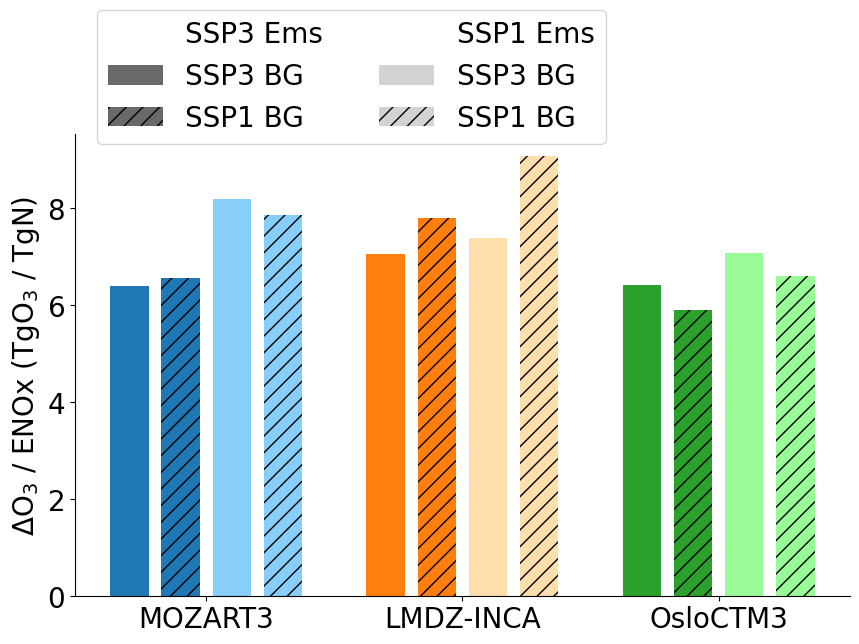

In [48]:
# Data
labels =['MOZART3','LMDZ-INCA','OsloCTM3']
values1 = o3_Rf_diff_SSP3_C1_1['o3_burden'].values/[1.713,1.785,1.761]*5  # First bar in each pair
values2 = o3_Rf_diff_SSP1BG_SSP3ems_C1_1['o3_burden'].values/[1.713,1.785,1.761]*5  # Second bar in each pair
values3 = o3_Rf_diff_SSP1_C1_1['o3_burden'].values/[0.845,0.88,0.87]*5
values4 = o3_Rf_diff_SSP3BG_SSP1ems_C1_1['o3_burden'].values/[0.845,0.88,0.87]*5

# Bar width and positions
x = np.arange(len(labels))
width = 0.15  # Reduced width to create gap
spacing = 0.05  # Small gap between bars

# Colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
colors2 = ['lightskyblue', 'navajowhite', 'palegreen']

# Create figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# Plot bars
bars1 = ax.bar(x - 0.3, values1, width, color=colors, label='Set 1')
bars2 = ax.bar(x - 0.1, values2, width, color=colors, hatch='//', label='Set 2')
bars3 = ax.bar(x + 0.1, values4, width, color=colors2, label='Set 3')
bars4 = ax.bar(x + 0.3, values3, width, color=colors2, hatch='//', label='Set 4')


legend_elements = [Patch(facecolor='white', label='SSP3 Ems'),
                   Patch(facecolor='dimgrey', label='SSP3 BG'),
                   Patch(facecolor='dimgrey', hatch='//', label='SSP1 BG'),
                   Patch(facecolor='white', label='SSP1 Ems'),
                   Patch(facecolor='lightgray', label='SSP3 BG'),
                   Patch(facecolor='lightgray', hatch='//', label='SSP1 BG')]

# Labels and title
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.spines[['right', 'top']].set_visible(False)

ax.set_ylabel(f'$\Delta$O$_3$ / ENOx (TgO$_3$ / TgN)')
#ax.set_title('Paired Bar Chart with Hatching')
ax.legend(handles=legend_elements, bbox_to_anchor=(0.01, 1.3), loc='upper left',ncol=2)
#plt.savefig(f'{plotdir}/ACACIA_O3conc_bar_bgdiff_FigS1a.pdf',format='pdf',bbox_inches='tight')